In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import catboost as cb
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook
from datetime import date, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.losses import MSLE as keras_MSLE
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
sns.set()

SEED = 1337
FOLDS = 10

def MSLE(y_true, y_pred):
    return ((np.log(y_true+1)-np.log(y_pred+1))**2).mean()

In [ ]:
train = pd.read_csv('train.csv', parse_dates=['Дата']).iloc[:, 1:].drop(['Год', 'Месяц', 'День', 'Время', 'Дата_День', 'next_day'], axis=1)
test = pd.read_csv('test.csv', parse_dates=['Дата']).iloc[:, 1:]

In [ ]:
# HOLIDAYS PROCESSING
pc = pd.read_csv('product_calendar.csv').iloc[:, :-5]
pc.columns = ['year']+[i for i in range(1, 13)]
pc = pc[(pc['year'] <= 2020) & (pc['year'] >= 2018)]
for i in range(1, 13):
    pc.loc[:, i] = pc.loc[:, i].str.replace('*', '').str.replace('+', '')
    pc.loc[:, i] = pc.loc[:, i].str.split(',')

holidays = []
for i, row in pc.iterrows():
    y = str(row['year'])
    for m in range(1, 13):
        for k in row[m]:
            holidays.append(str(y)+'-'+str(m)+'-'+str(k))
qsdate = date(2020,3,28)
qedate = date(2020,5,11)
quarantine_holidays = list(pd.date_range(qsdate,qedate,freq='d').astype(str))
holidays += quarantine_holidays
holidays = pd.to_datetime(pd.Series(holidays), format='%Y-%m-%d')

In [ ]:
train['dateNoTime'] = pd.to_datetime(train['Дата'].apply(lambda x: '-'.join((str(x.year), str(x.month), str(x.day)))), format="%Y-%m-%d")
train['year'] = train['Дата'].apply(lambda x: x.year)
train['month'] = train['Дата'].apply(lambda x: x.month)
train['day'] = train['Дата'].apply(lambda x: x.day)
train['hour'] = train['Дата'].apply(lambda x: x.hour)
train['dow'] = train['Дата'].dt.dayofweek
train['is_holiday'] = train['dateNoTime'].isin(holidays)*1
train['season'] = 0
train['season'][train['month'].isin([12, 1, 2])] = 0
train['season'][train['month'].isin([3, 4, 5])] = 1
train['season'][train['month'].isin([6, 7, 8])] = 2
train['season'][train['month'].isin([9, 10, 11])] = 3

train['tod'] = 0
train['tod'][train['hour'] < 8] = 0
train['tod'][(train['hour'] >= 8) & (train['hour'] < 16)] = 1
train['tod'][(train['hour'] >= 16)] = 2

# train['is_before_holiday'] = train['dateNoTime'].apply(lambda x: closest_holiday(x, 'before'))
# train['is_after_holiday'] = train['dateNoTime'].apply(lambda x: closest_holiday(x, 'after'))
train = train.drop('dateNoTime', axis=1)

train['TVR/SHARE_18+'] = train['Все 18+_TVR']/train['Все 18+_Share']
train['TVR/SHARE_55+'] = train['Все 55+_TVR']/train['Все 55+_Share']
train['Все 18+_TVR_sin'] = np.sin(train['Все 18+_TVR'])
train['Все 55+_TVR_sin'] = np.sin(train['Все 55+_TVR'])
train['Все 18+_Share_sin'] = np.sin(train['Все 18+_Share'])
train['Все 55+_Share_sin'] = np.sin(train['Все 55+_Share'])

test['dateNoTime'] = pd.to_datetime(test['Дата'].apply(lambda x: '-'.join((str(x.year), str(x.month), str(x.day)))), format="%Y-%m-%d")
test['year'] = test['Дата'].apply(lambda x: x.year)
test['month'] = test['Дата'].apply(lambda x: x.month)
test['day'] = test['Дата'].apply(lambda x: x.day)
test['hour'] = test['Дата'].apply(lambda x: x.hour)
test['dow'] = test['Дата'].dt.dayofweek
test['is_holiday'] = test['dateNoTime'].isin(holidays)*1
test['season'] = 0
test['season'][test['month'].isin([12, 1, 2])] = 0
test['season'][test['month'].isin([3, 4, 5])] = 1
test['season'][test['month'].isin([6, 7, 8])] = 2
test['season'][test['month'].isin([9, 10, 11])] = 3

test['tod'] = 0
test['tod'][test['hour'] < 8] = 0
test['tod'][(test['hour'] >= 8) & (test['hour'] < 16)] = 1
test['tod'][(test['hour'] >= 16)] = 2
# test['is_before_holiday'] = test['dateNoTime'].apply(lambda x: closest_holiday(x, 'before'))
# test['is_after_holiday'] = test['dateNoTime'].apply(lambda x: closest_holiday(x, 'after'))
test = test.drop('dateNoTime', axis=1)

train.head()

,Канал,Все 18+_TVR,Все 55+_TVR,Все 18+_Share,Все 55+_Share,Дата,year,month,day,hour,dow,is_holiday,season,tod,TVR/SHARE_18+,TVR/SHARE_55+,Все 18+_TVR_sin,Все 55+_TVR_sin,Все 18+_Share_sin,Все 55+_Share_sin
0,ПЕРВЫЙ КАНАЛ,0.21,0.12,5.23,2.00,2018-11-01 05:00:00,2018,11,1,5,3,0,3,0,0.040153,0.060000,0.208460,0.119712,-0.869004,0.909297
1,ПЕРВЫЙ КАНАЛ,0.71,0.33,11.23,4.90,2018-11-01 06:00:00,2018,11,1,6,3,0,3,0,0.063224,0.067347,0.651834,0.324043,-0.972648,-0.982453
2,ПЕРВЫЙ КАНАЛ,1.10,0.59,14.58,6.49,2018-11-01 07:00:00,2018,11,1,7,3,0,3,0,0.075446,0.090909,0.891207,0.556361,0.903541,0.205344
3,ПЕРВЫЙ КАНАЛ,0.96,0.94,10.41,7.41,2018-11-01 08:00:00,2018,11,1,8,3,0,3,1,0.092219,0.126856,0.819192,0.807558,-0.833395,0.903049
4,ПЕРВЫЙ КАНАЛ,1.94,3.81,17.54,21.51,2018-11-01 09:00:00,2018,11,1,9,3,0,3,1,0.110604,0.177127,0.932615,-0.619737,-0.966070,0.462798


In [ ]:
def get_day(idx):
    return train[(train[['Канал', 'year', 'month', 'day']] == train.drop_duplicates(['year', 'month', 'day', 'Канал'])[['Канал', 'year', 'month', 'day']].iloc[idx]).sum(axis=1) == 4]
def get_month(idx):
    return train[(train[['Канал', 'year', 'month']] == train.drop_duplicates(['year', 'month', 'Канал'])[['Канал', 'year', 'month']].iloc[idx]).sum(axis=1) == 3]
def get_month_avg(idx):
    return train[(train[['Канал', 'year', 'month']] == train.drop_duplicates(['year', 'month', 'Канал'])[['Канал', 'year', 'month']].iloc[idx]).sum(axis=1) == 3].groupby(['Канал','month', 'day'])[['Все 18+_TVR', 'Все 55+_TVR', 'Все 18+_Share', 'Все 55+_Share']].mean().reset_index()

ПЕРВЫЙ КАНАЛ | Все 18+_TVR


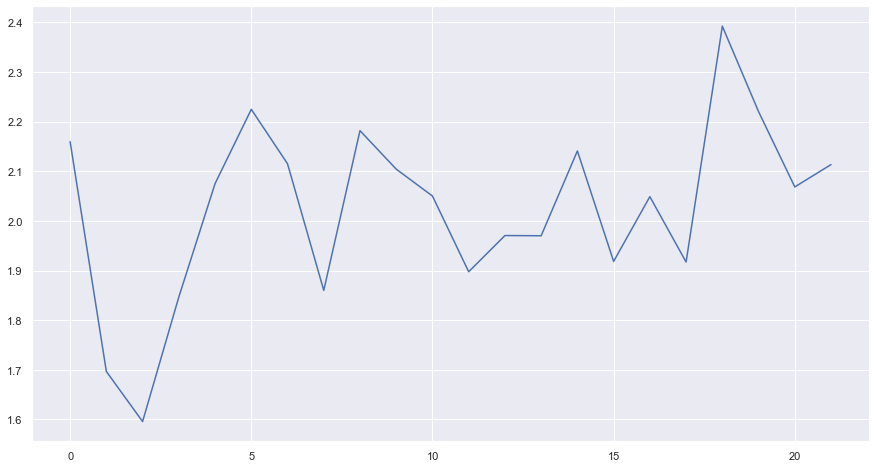

ПЕРВЫЙ КАНАЛ | Все 18+_TVR | ARCSIN


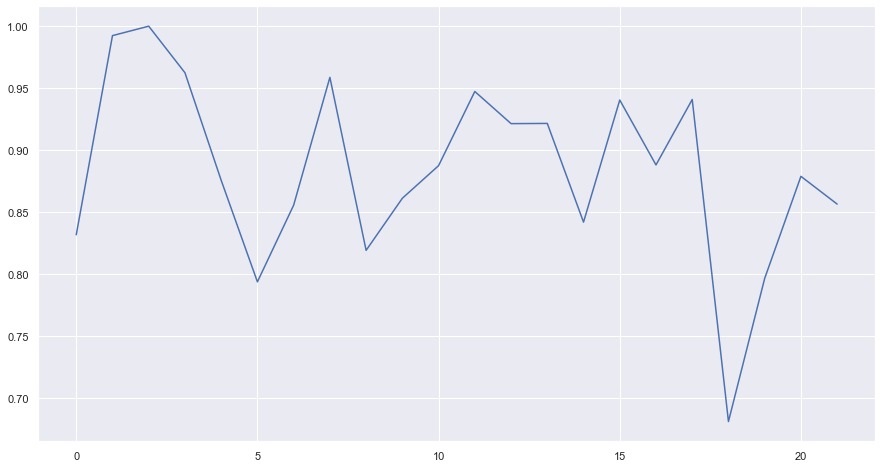

ПЕРВЫЙ КАНАЛ | Все 55+_TVR


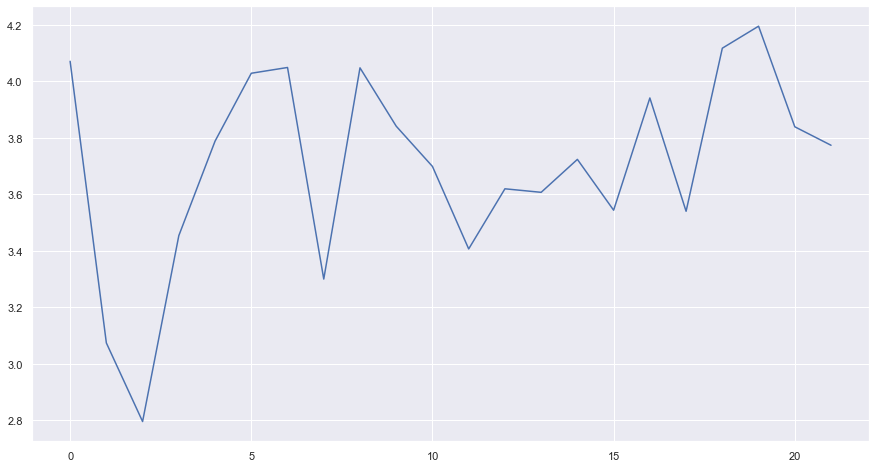

ПЕРВЫЙ КАНАЛ | Все 55+_TVR | ARCSIN


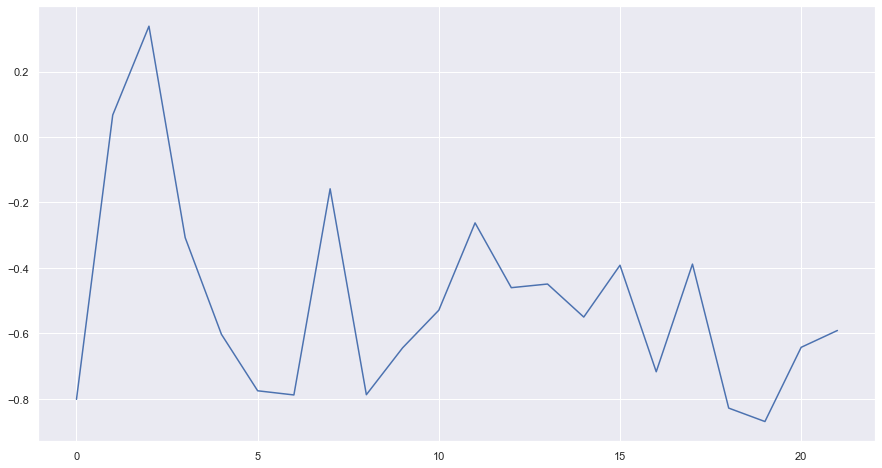

ПЕРВЫЙ КАНАЛ | Все 18+_Share


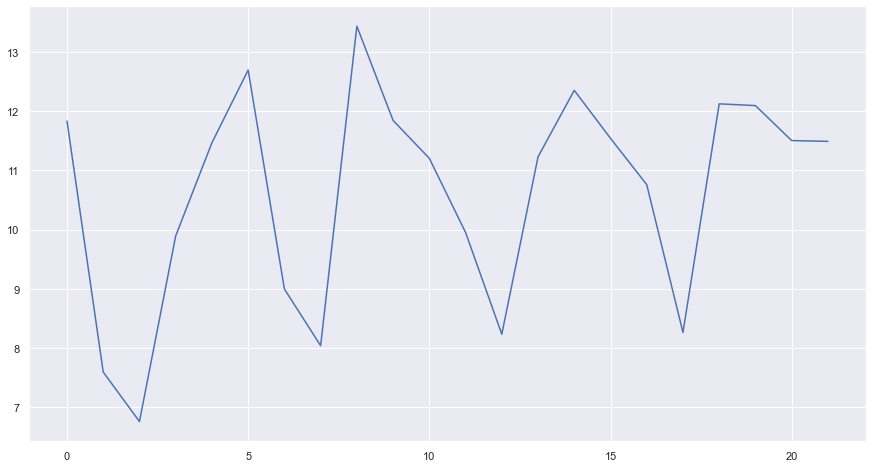

ПЕРВЫЙ КАНАЛ | Все 18+_Share | ARCSIN


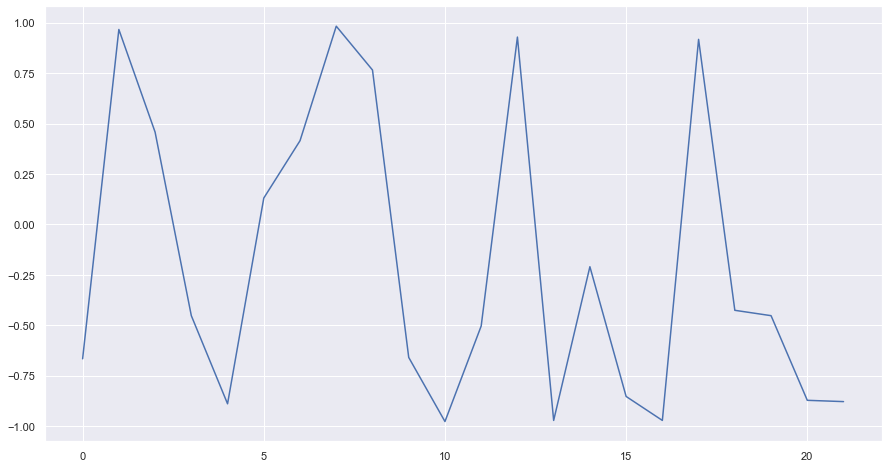

ПЕРВЫЙ КАНАЛ | Все 55+_Share


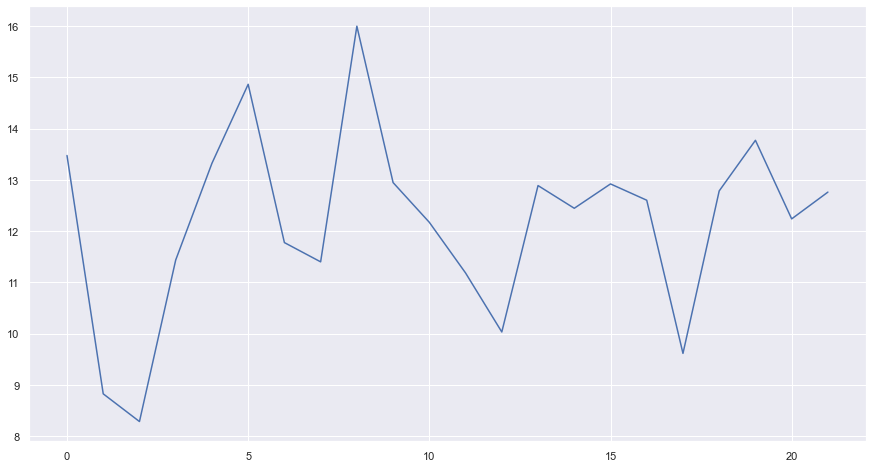

ПЕРВЫЙ КАНАЛ | Все 55+_Share | ARCSIN


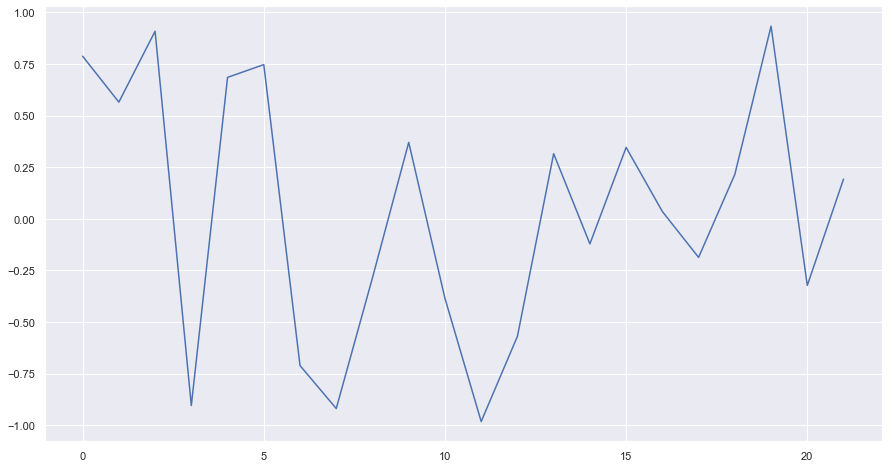

ПЕРВЫЙ КАНАЛ | Все 18+_TVR


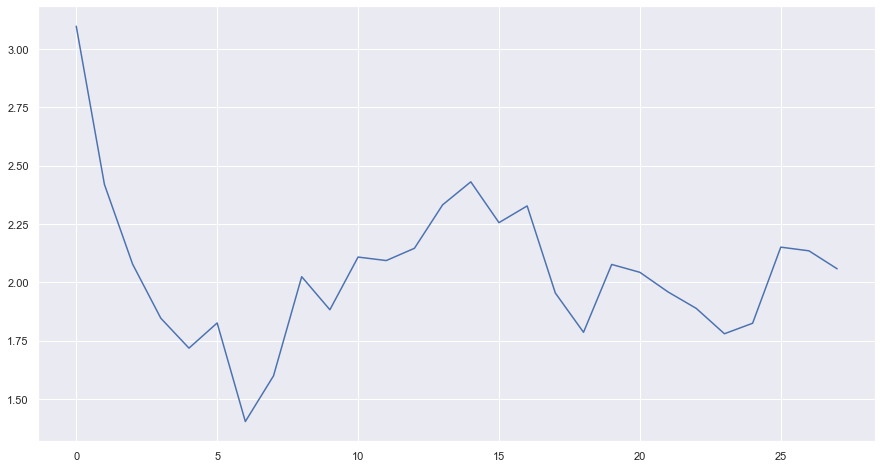

ПЕРВЫЙ КАНАЛ | Все 18+_TVR | ARCSIN


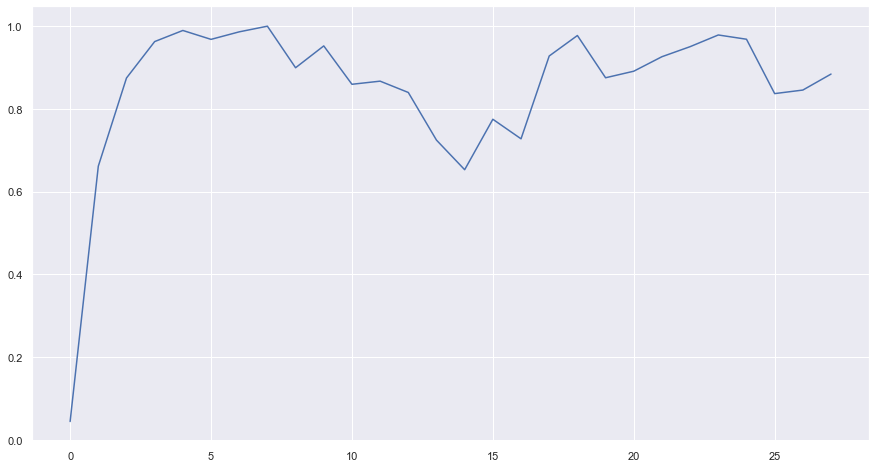

ПЕРВЫЙ КАНАЛ | Все 55+_TVR


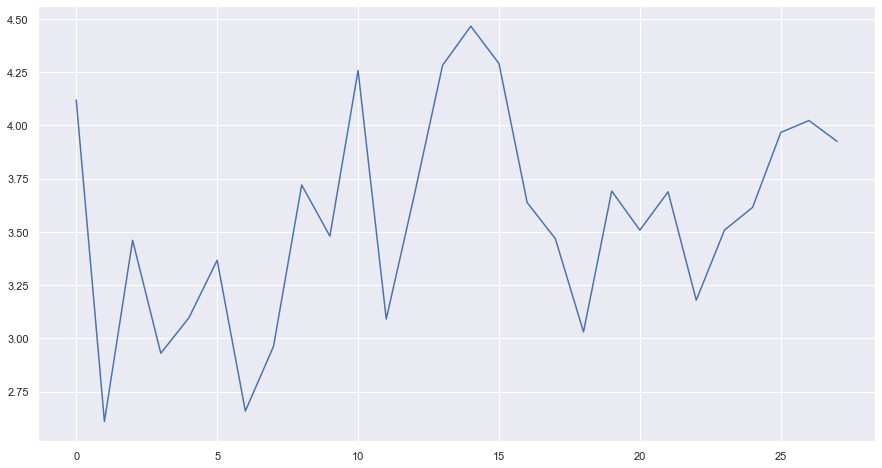

ПЕРВЫЙ КАНАЛ | Все 55+_TVR | ARCSIN


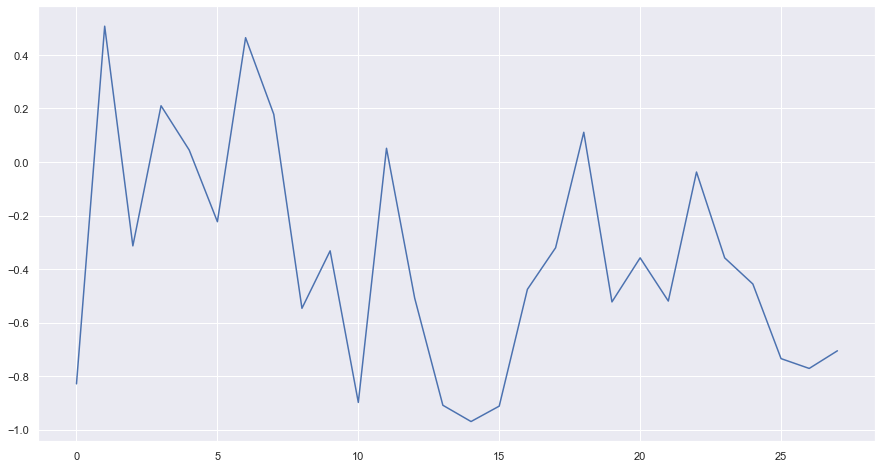

ПЕРВЫЙ КАНАЛ | Все 18+_Share


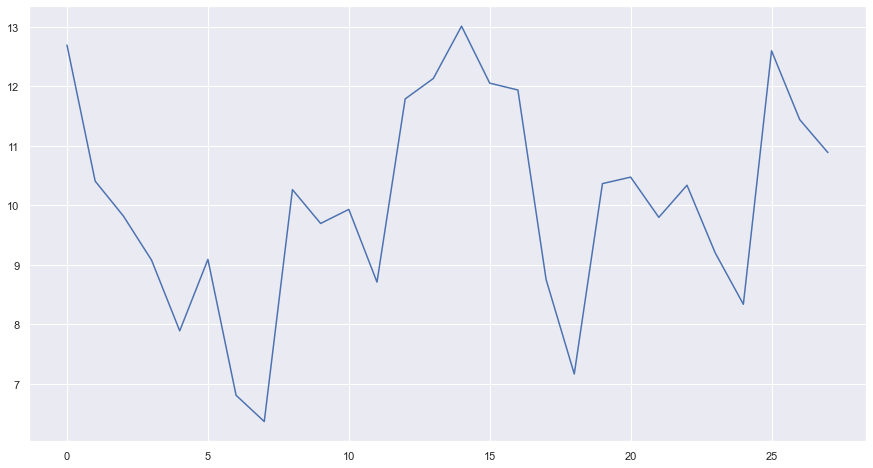

ПЕРВЫЙ КАНАЛ | Все 18+_Share | ARCSIN


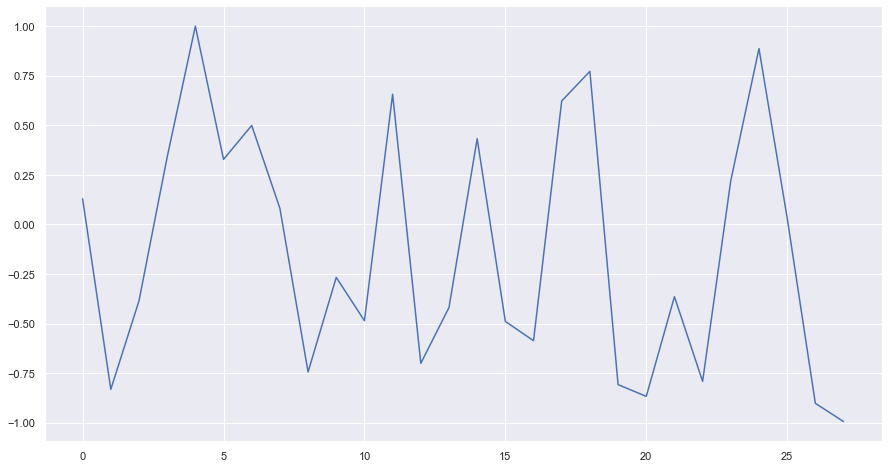

ПЕРВЫЙ КАНАЛ | Все 55+_Share


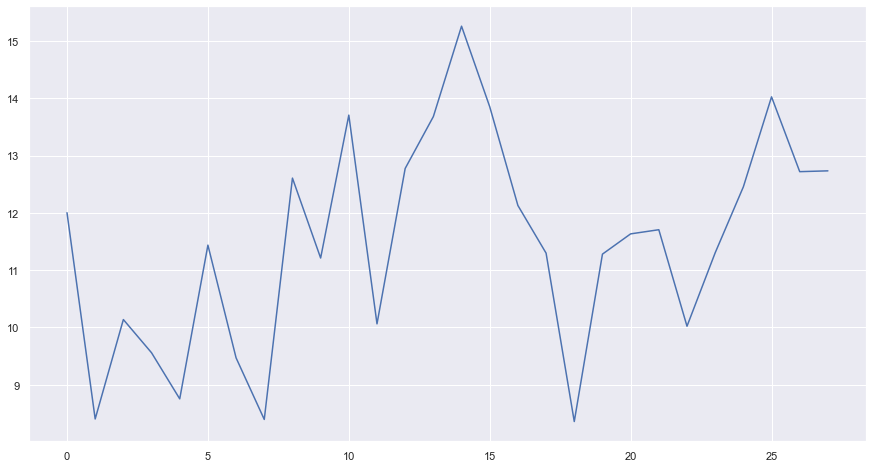

ПЕРВЫЙ КАНАЛ | Все 55+_Share | ARCSIN


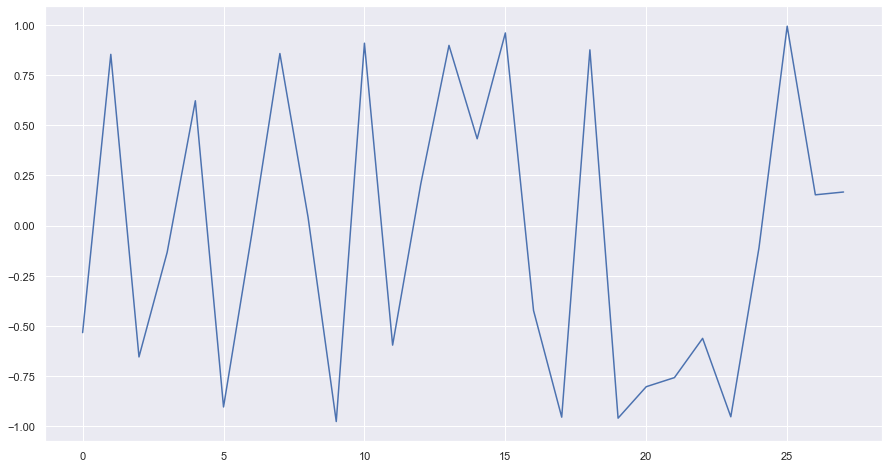

ПЕРВЫЙ КАНАЛ | Все 18+_TVR


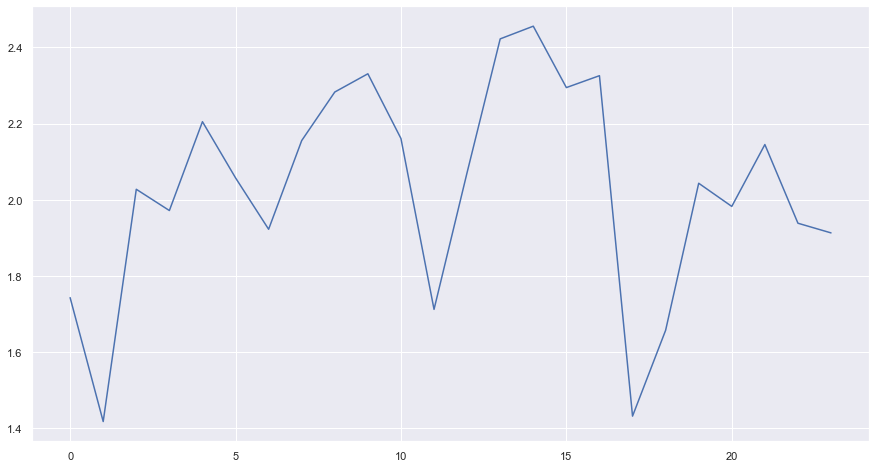

ПЕРВЫЙ КАНАЛ | Все 18+_TVR | ARCSIN


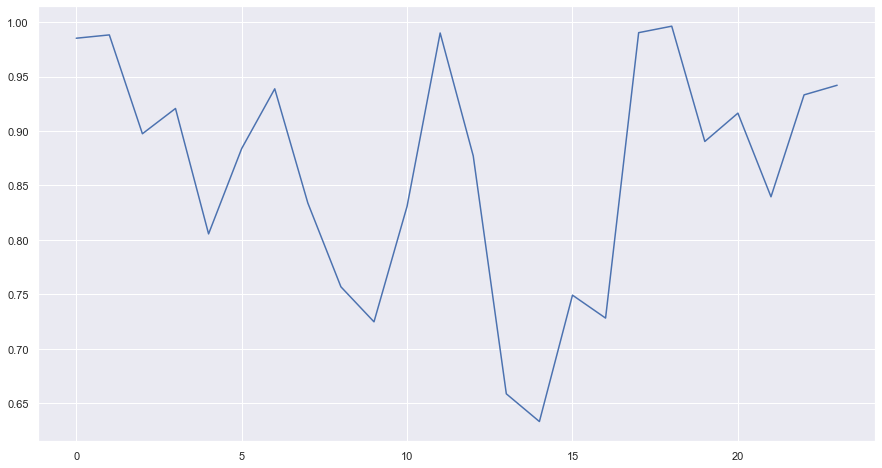

ПЕРВЫЙ КАНАЛ | Все 55+_TVR


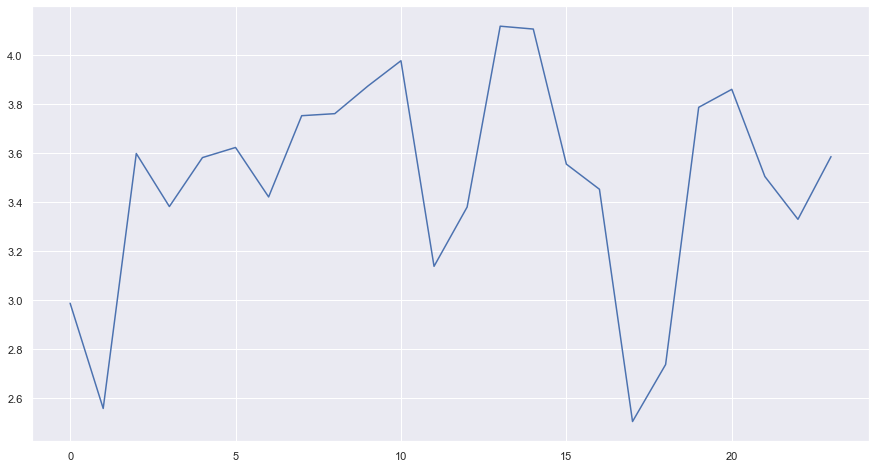

ПЕРВЫЙ КАНАЛ | Все 55+_TVR | ARCSIN


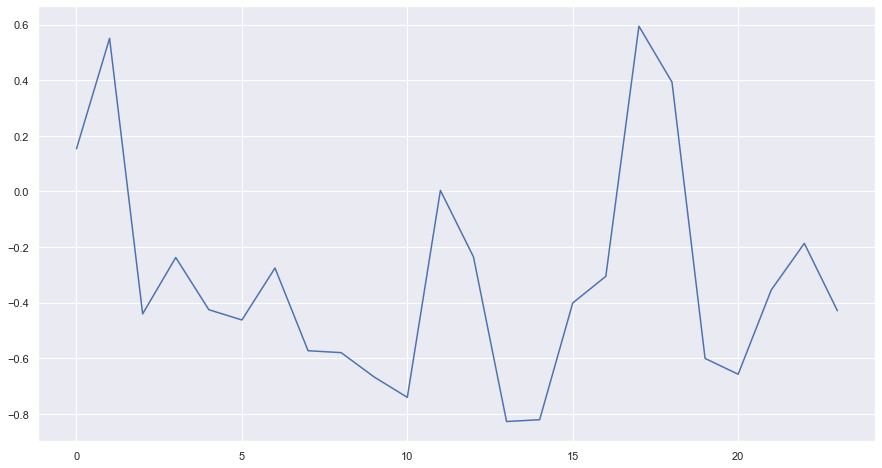

ПЕРВЫЙ КАНАЛ | Все 18+_Share


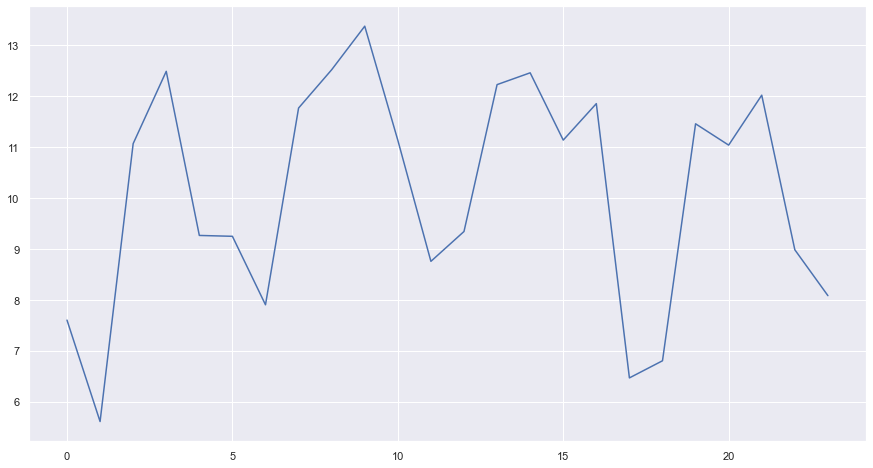

ПЕРВЫЙ КАНАЛ | Все 18+_Share | ARCSIN


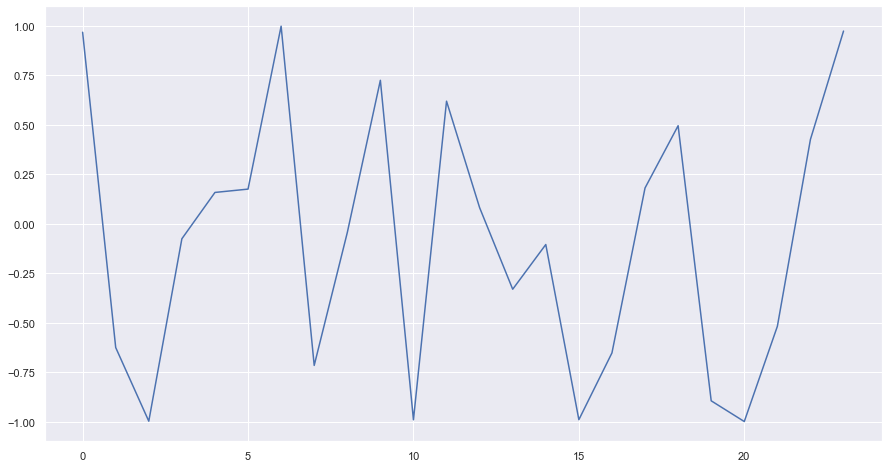

ПЕРВЫЙ КАНАЛ | Все 55+_Share


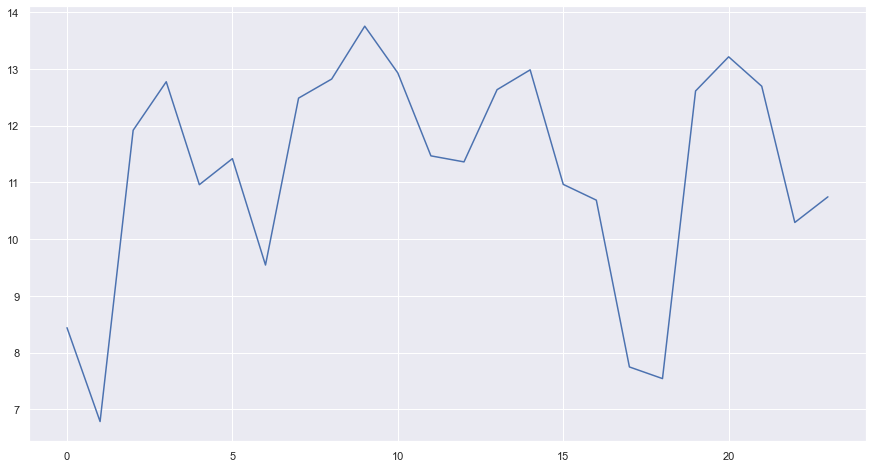

ПЕРВЫЙ КАНАЛ | Все 55+_Share | ARCSIN


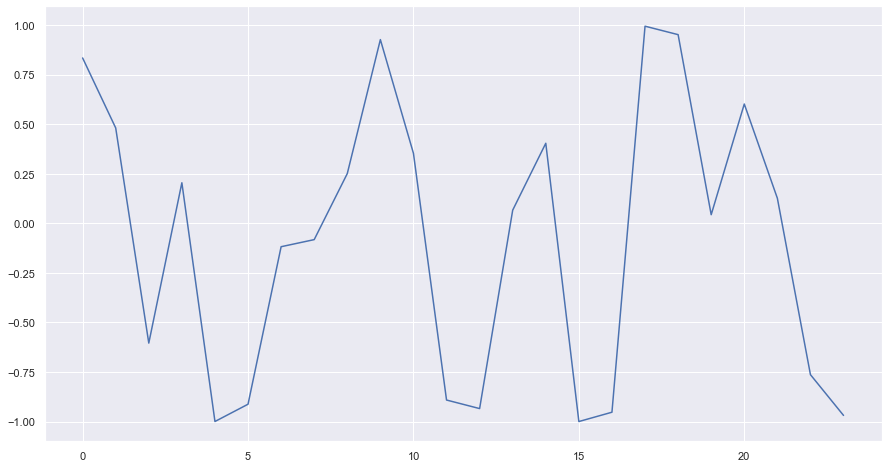

ПЕРВЫЙ КАНАЛ | Все 18+_TVR


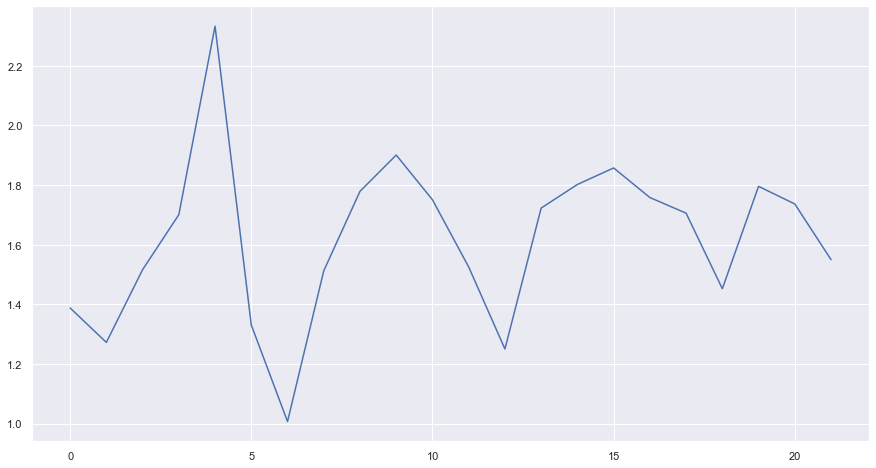

ПЕРВЫЙ КАНАЛ | Все 18+_TVR | ARCSIN


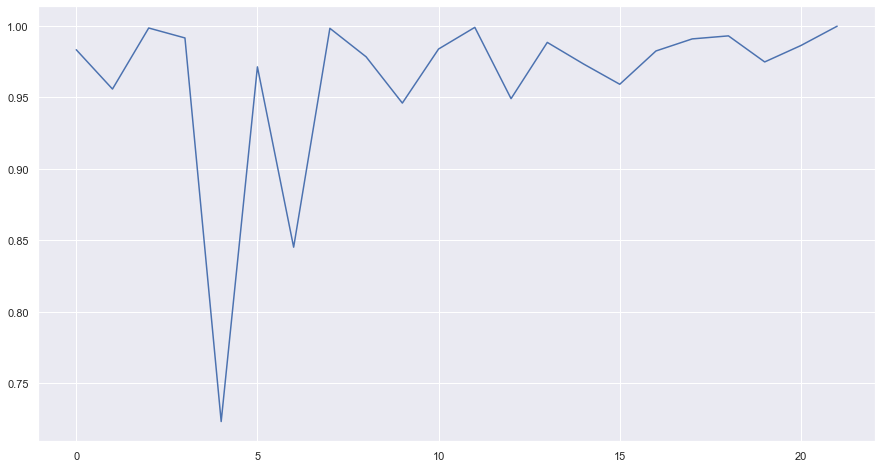

ПЕРВЫЙ КАНАЛ | Все 55+_TVR


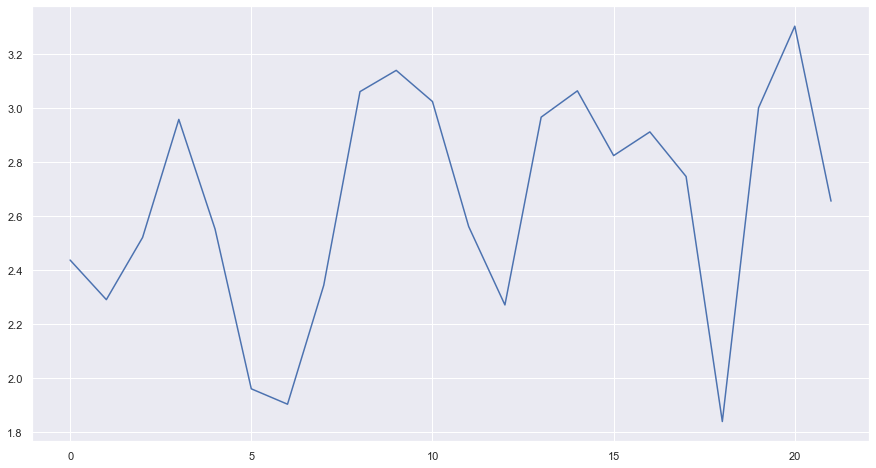

ПЕРВЫЙ КАНАЛ | Все 55+_TVR | ARCSIN


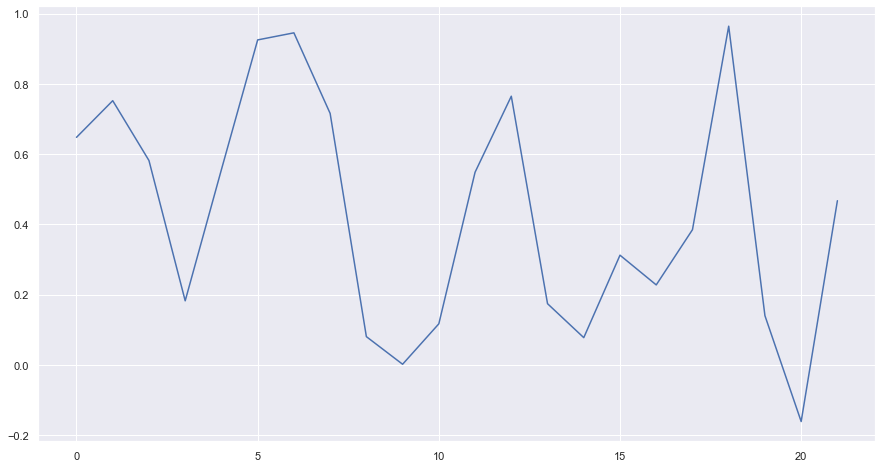

ПЕРВЫЙ КАНАЛ | Все 18+_Share


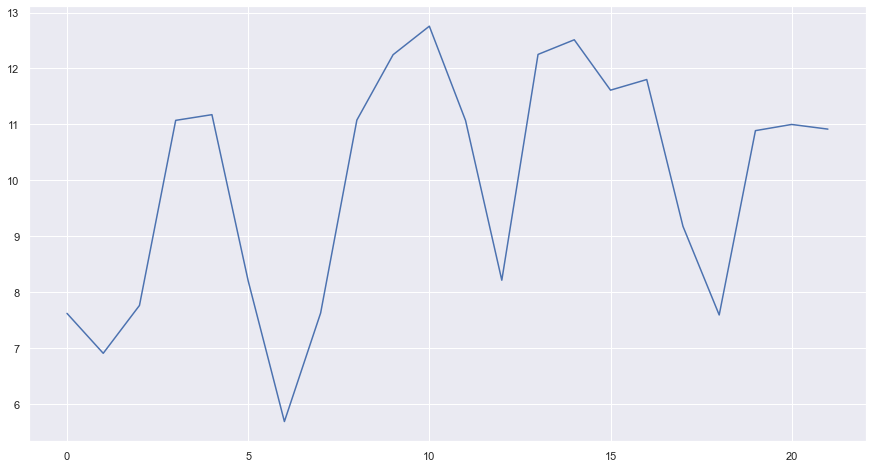

ПЕРВЫЙ КАНАЛ | Все 18+_Share | ARCSIN


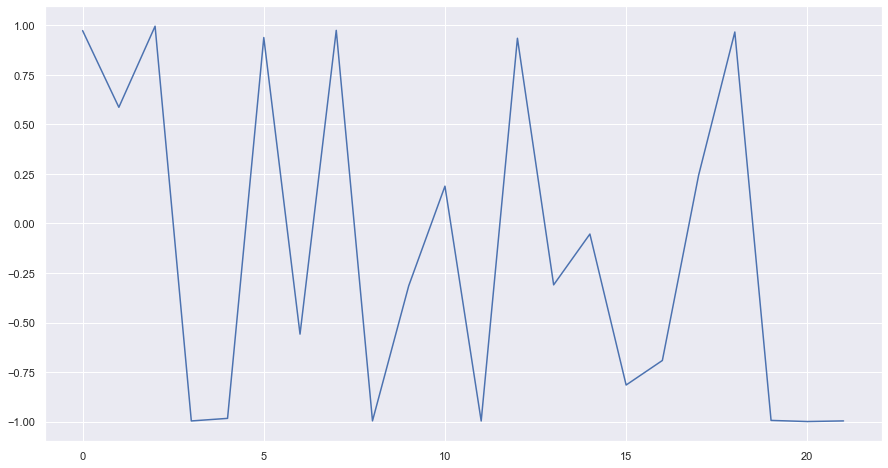

ПЕРВЫЙ КАНАЛ | Все 55+_Share


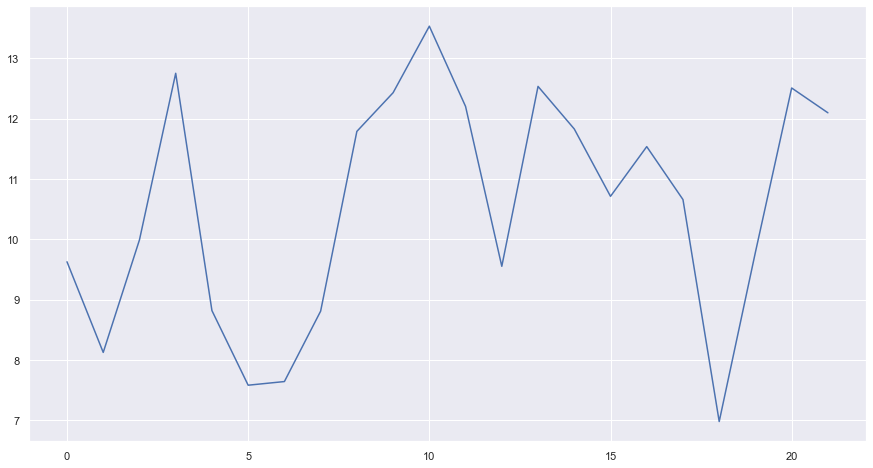

ПЕРВЫЙ КАНАЛ | Все 55+_Share | ARCSIN


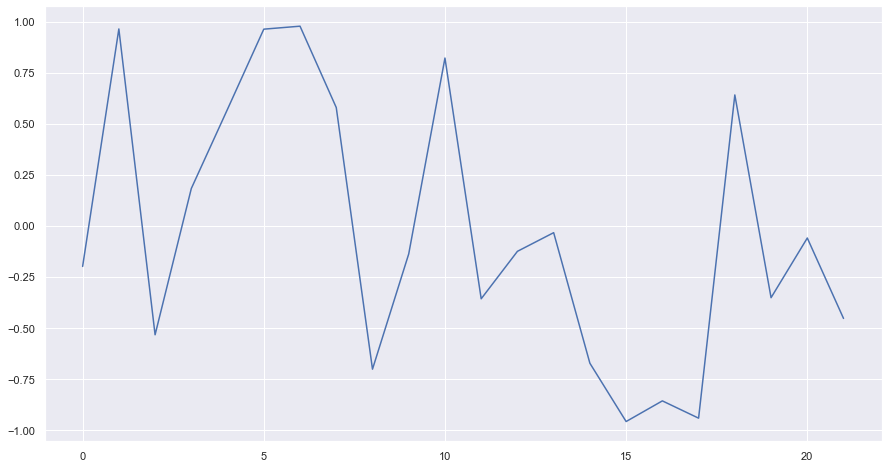

ПЕРВЫЙ КАНАЛ | Все 18+_TVR


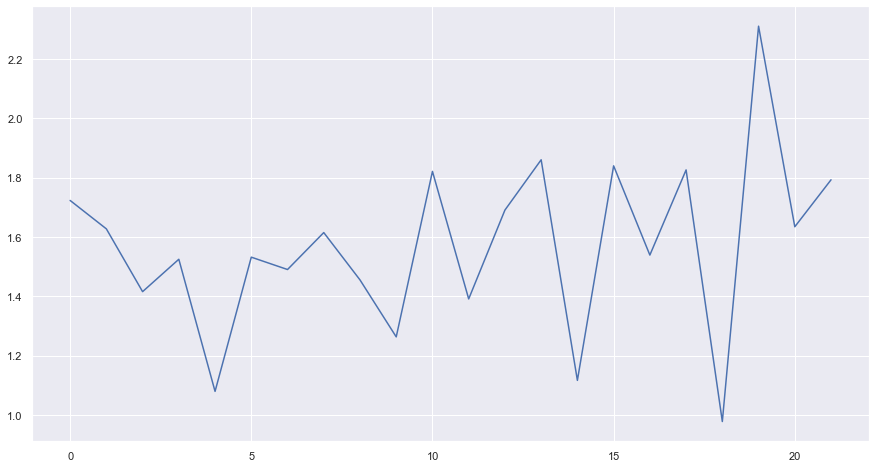

ПЕРВЫЙ КАНАЛ | Все 18+_TVR | ARCSIN


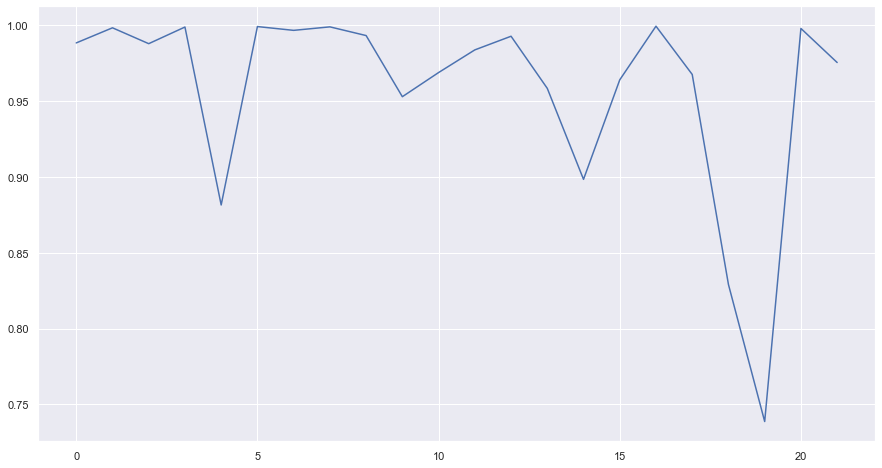

ПЕРВЫЙ КАНАЛ | Все 55+_TVR


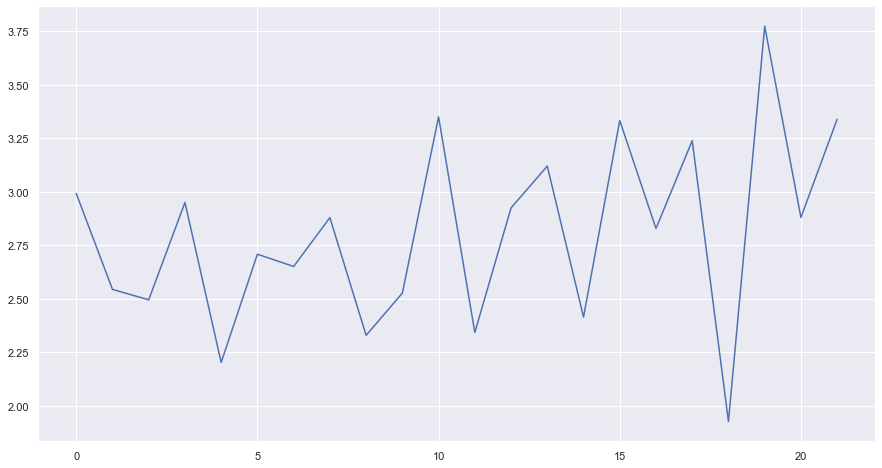

ПЕРВЫЙ КАНАЛ | Все 55+_TVR | ARCSIN


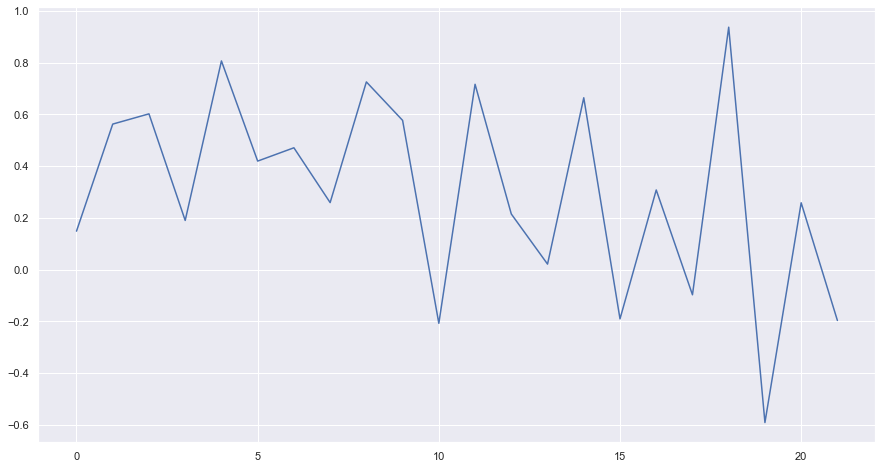

ПЕРВЫЙ КАНАЛ | Все 18+_Share


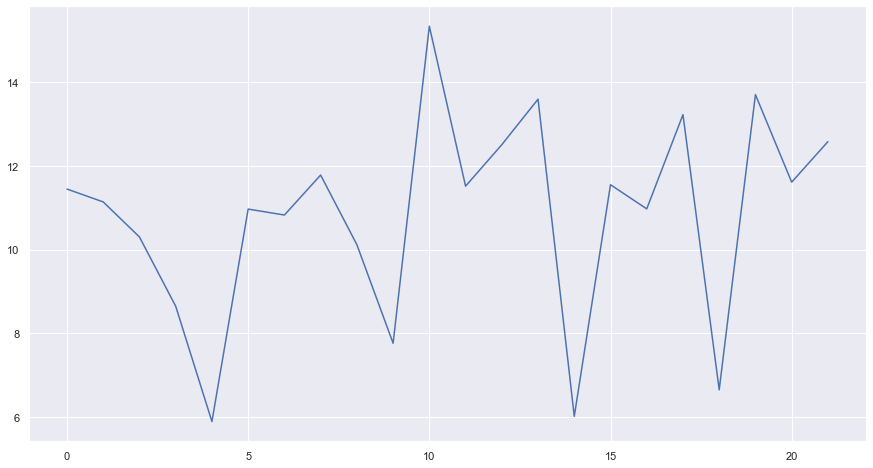

ПЕРВЫЙ КАНАЛ | Все 18+_Share | ARCSIN


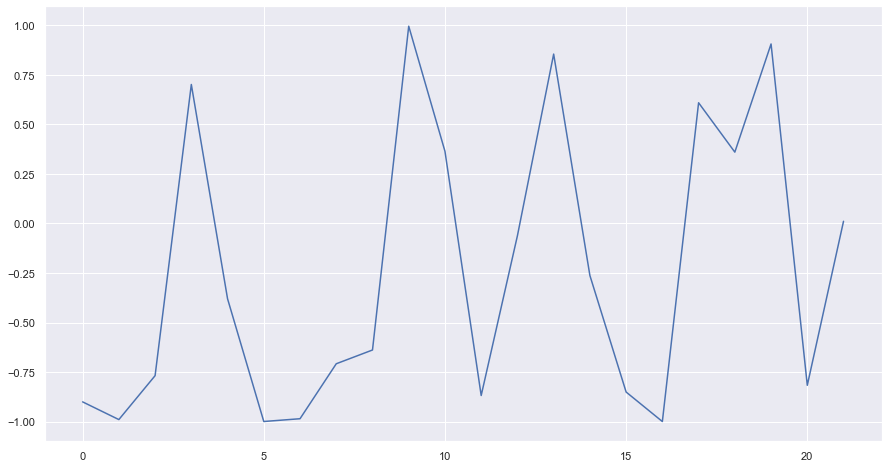

ПЕРВЫЙ КАНАЛ | Все 55+_Share


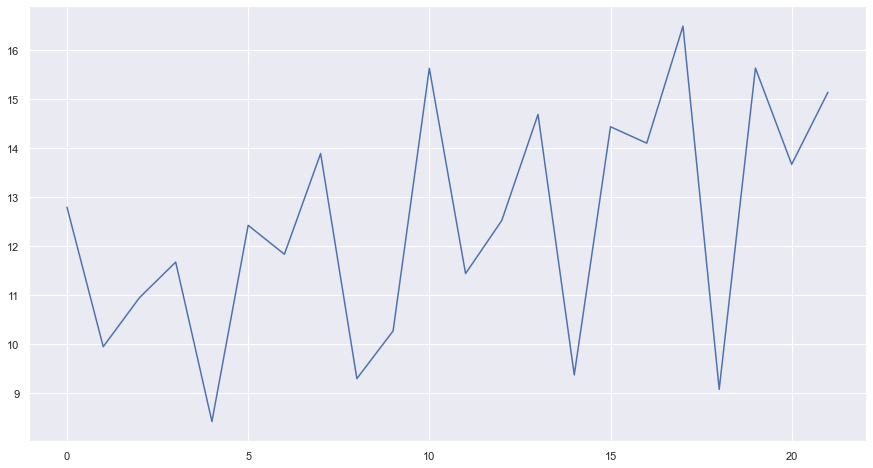

ПЕРВЫЙ КАНАЛ | Все 55+_Share | ARCSIN


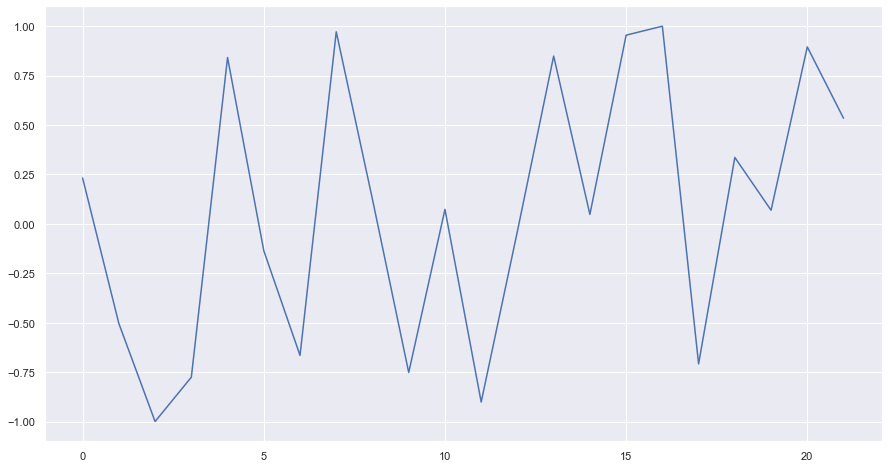

ПЕРВЫЙ КАНАЛ | Все 18+_TVR


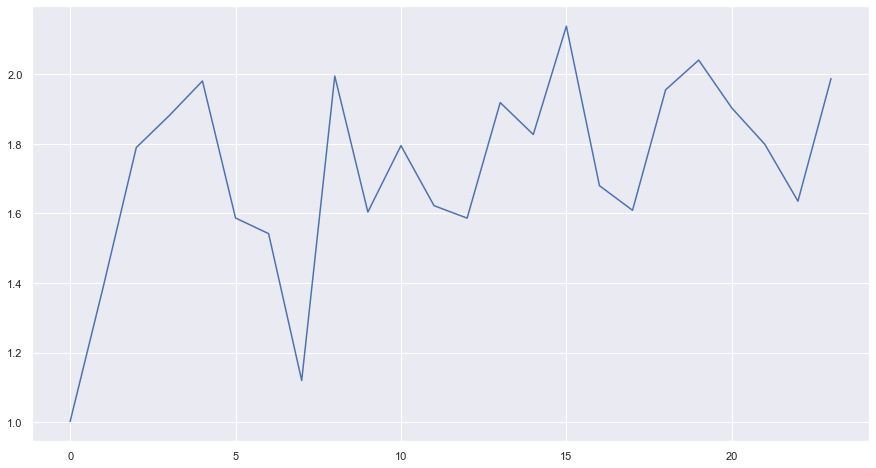

ПЕРВЫЙ КАНАЛ | Все 18+_TVR | ARCSIN


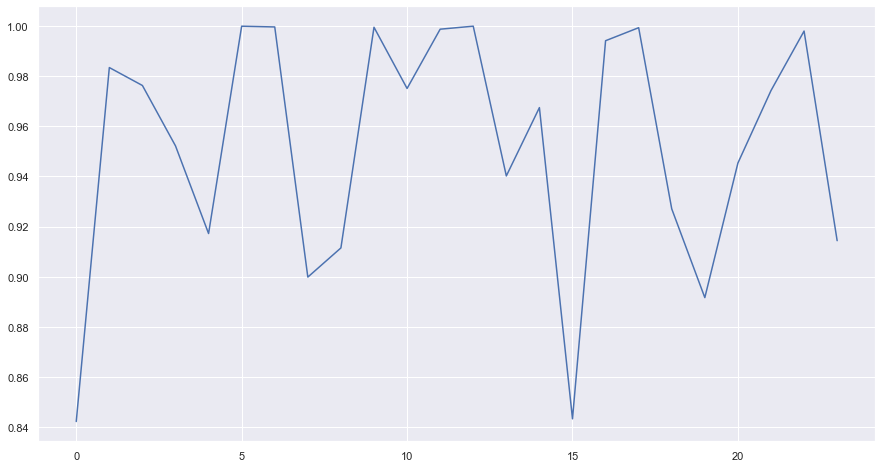

ПЕРВЫЙ КАНАЛ | Все 55+_TVR


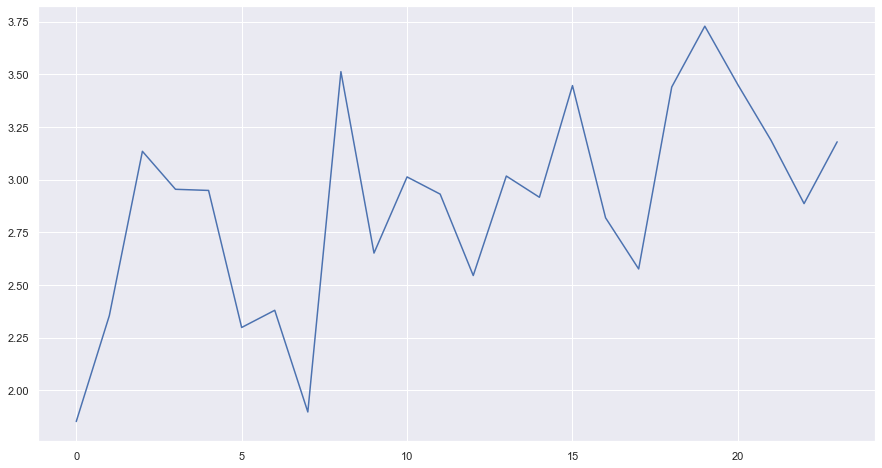

ПЕРВЫЙ КАНАЛ | Все 55+_TVR | ARCSIN


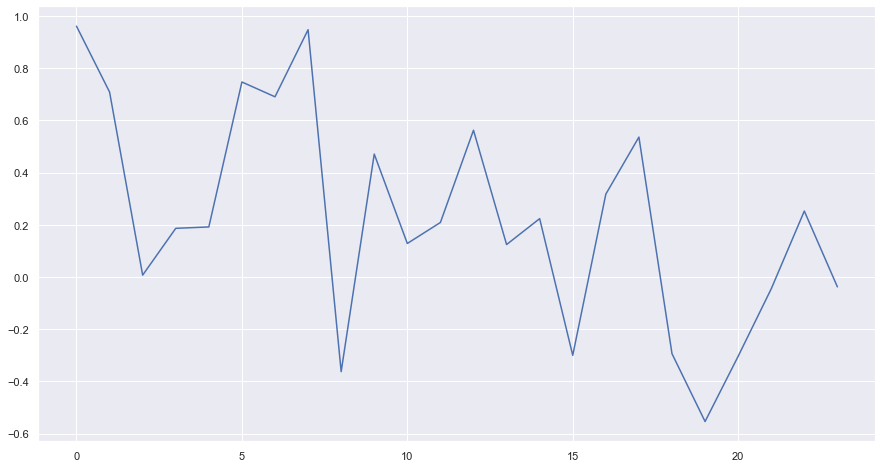

ПЕРВЫЙ КАНАЛ | Все 18+_Share


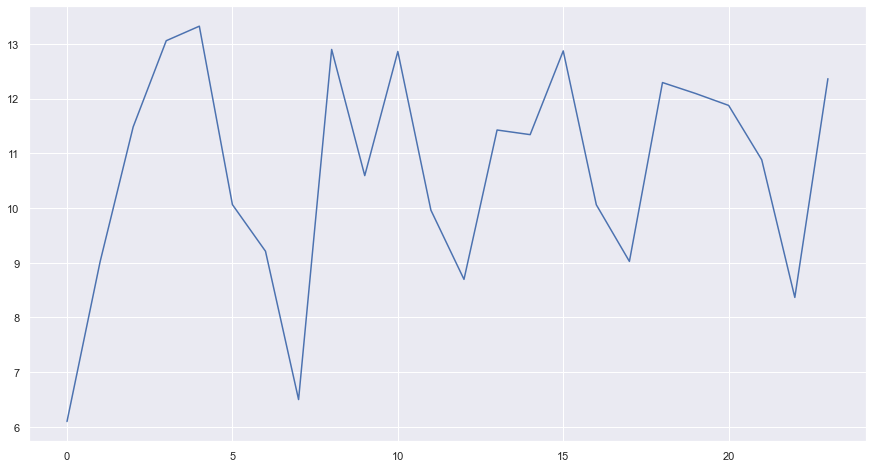

ПЕРВЫЙ КАНАЛ | Все 18+_Share | ARCSIN


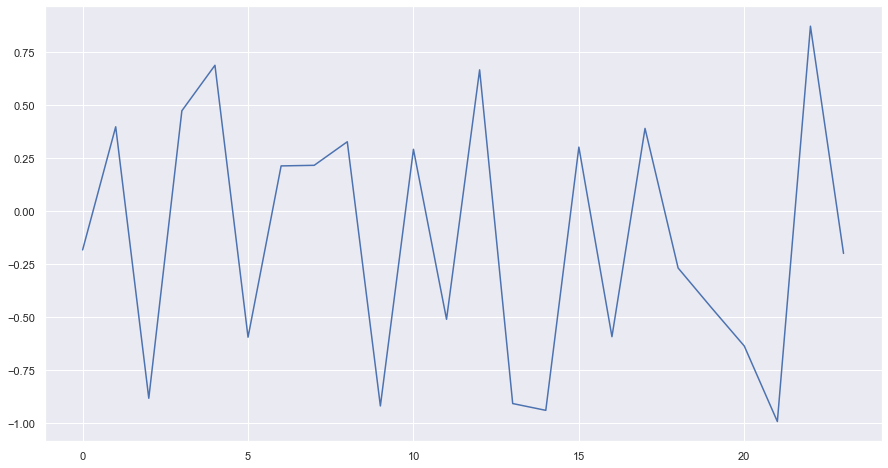

ПЕРВЫЙ КАНАЛ | Все 55+_Share


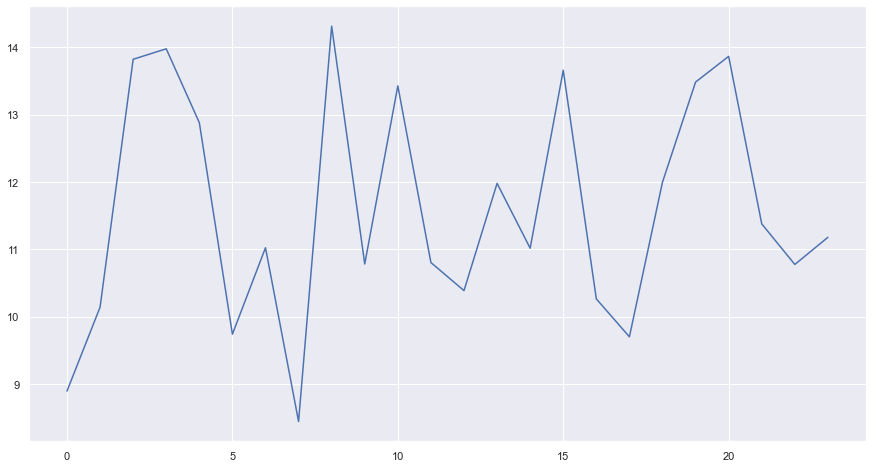

ПЕРВЫЙ КАНАЛ | Все 55+_Share | ARCSIN


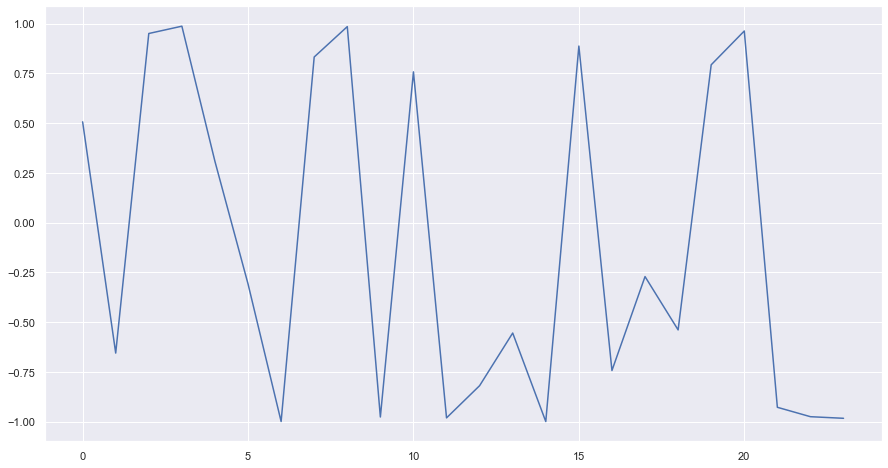

ПЕРВЫЙ КАНАЛ | Все 18+_TVR


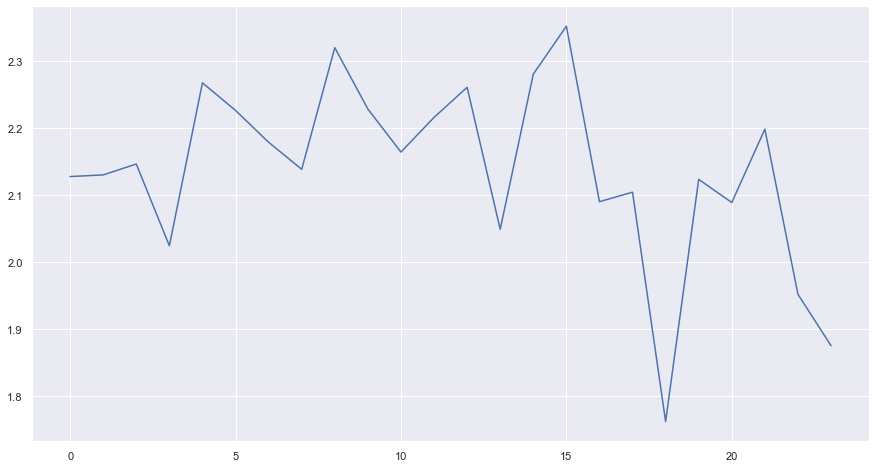

ПЕРВЫЙ КАНАЛ | Все 18+_TVR | ARCSIN


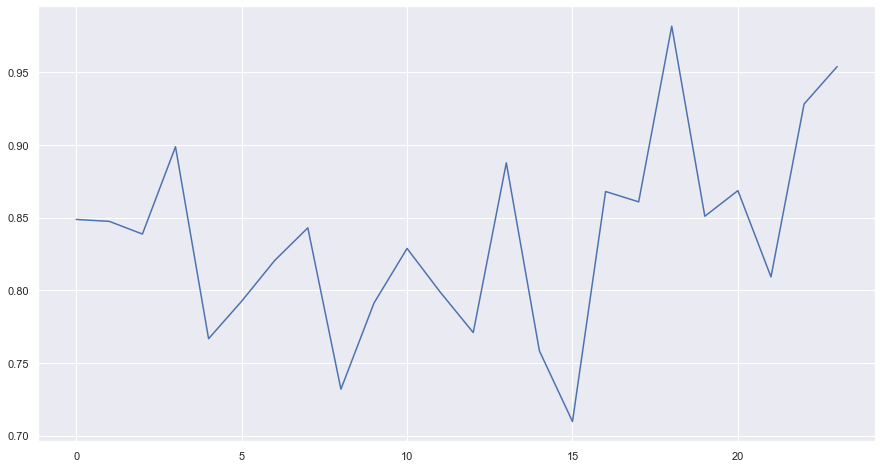

ПЕРВЫЙ КАНАЛ | Все 55+_TVR


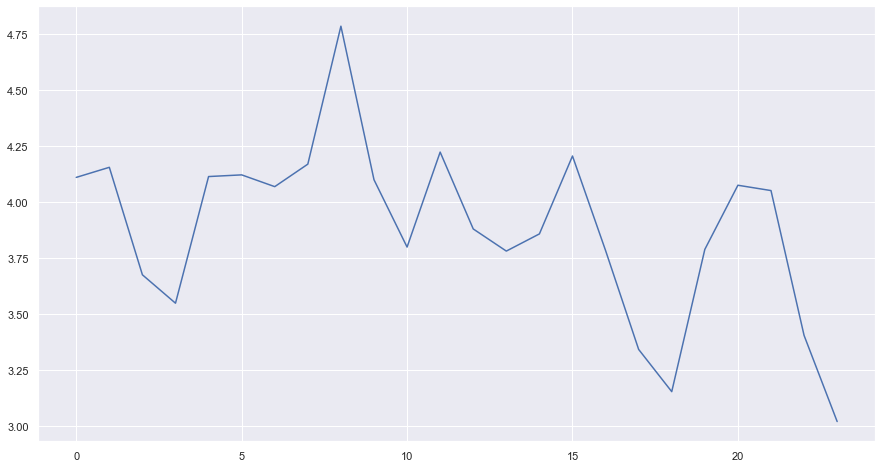

ПЕРВЫЙ КАНАЛ | Все 55+_TVR | ARCSIN


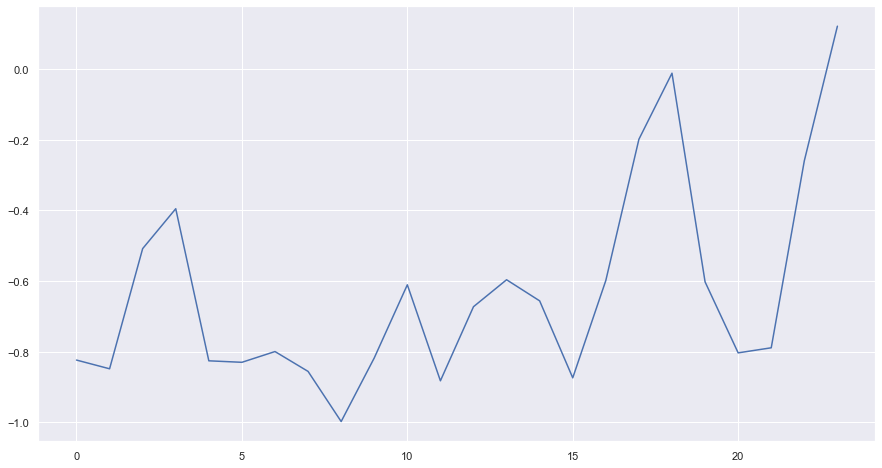

ПЕРВЫЙ КАНАЛ | Все 18+_Share


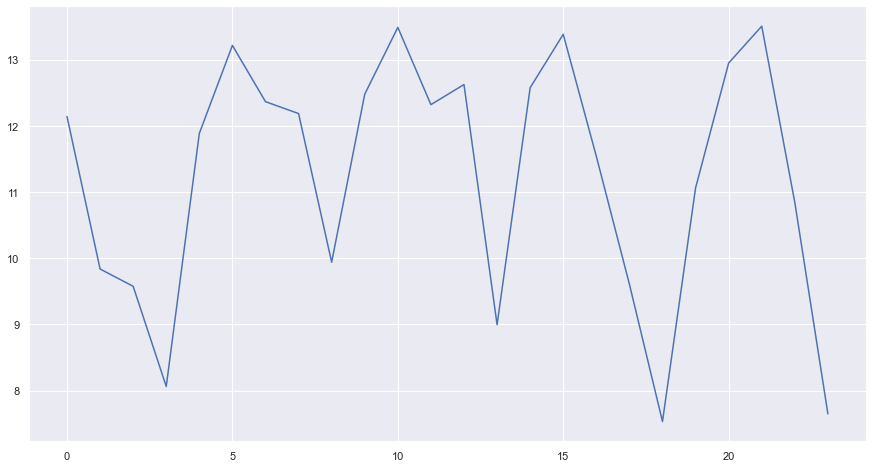

ПЕРВЫЙ КАНАЛ | Все 18+_Share | ARCSIN


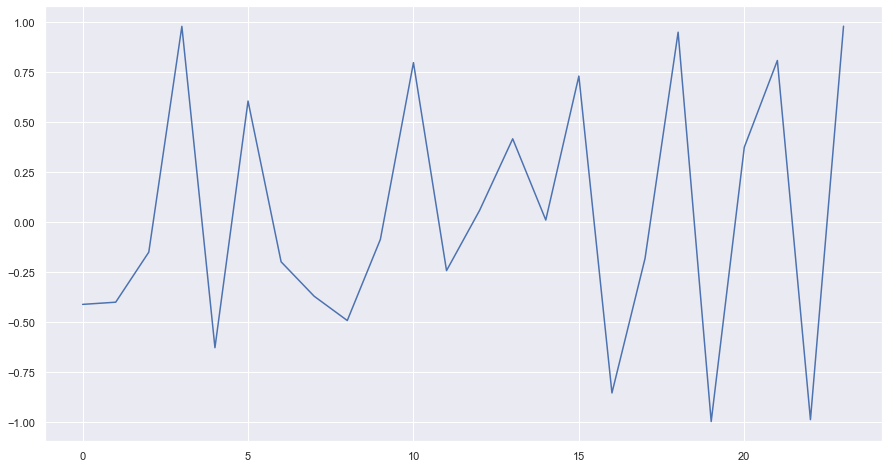

ПЕРВЫЙ КАНАЛ | Все 55+_Share


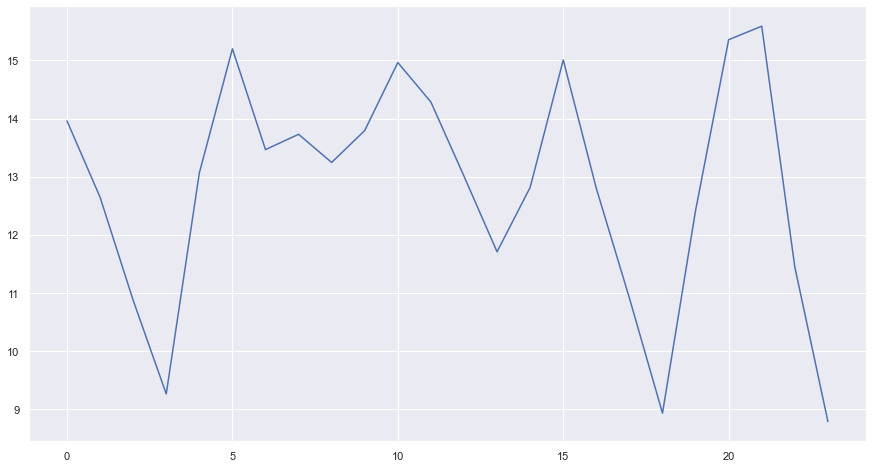

ПЕРВЫЙ КАНАЛ | Все 55+_Share | ARCSIN


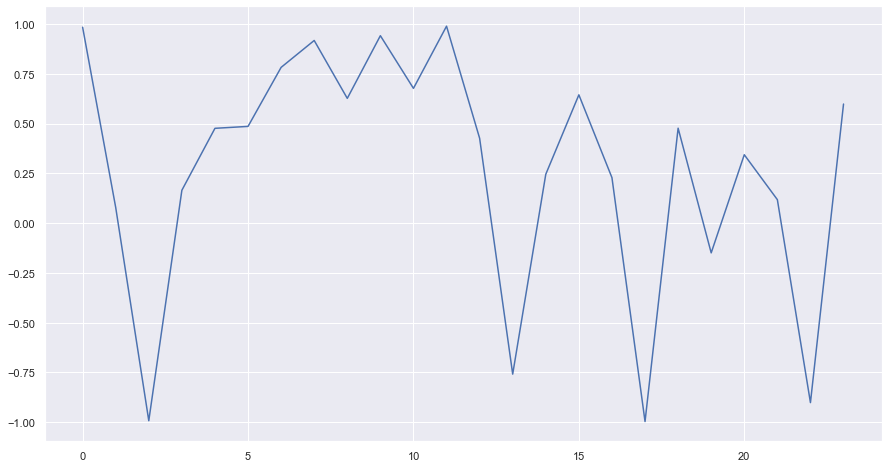

ПЕРВЫЙ КАНАЛ | Все 18+_TVR


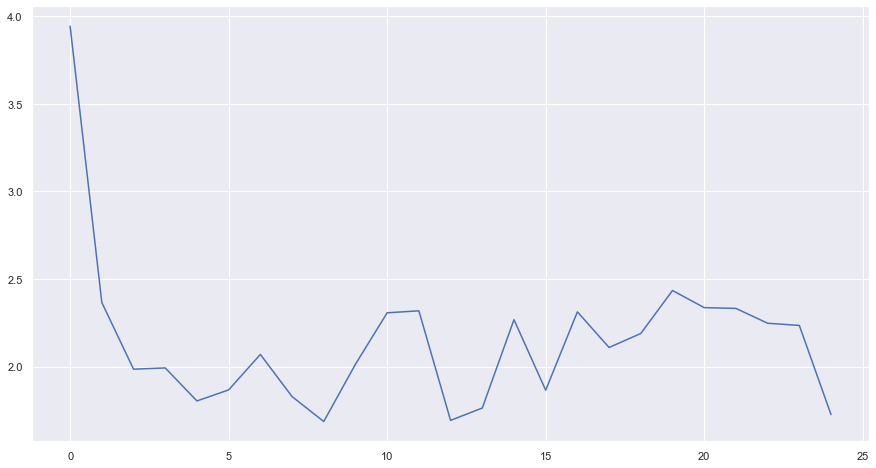

ПЕРВЫЙ КАНАЛ | Все 18+_TVR | ARCSIN


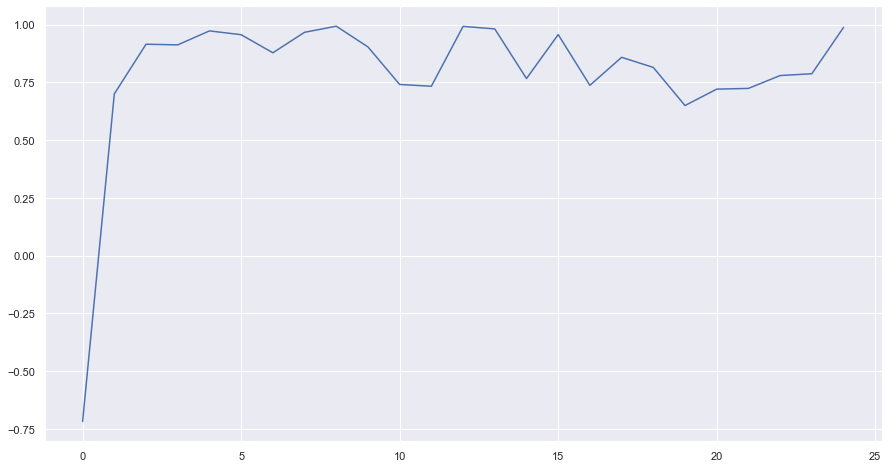

ПЕРВЫЙ КАНАЛ | Все 55+_TVR


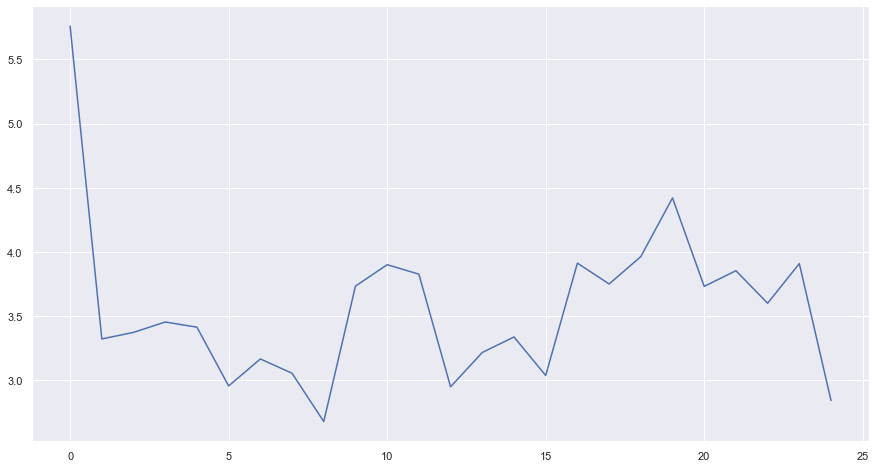

ПЕРВЫЙ КАНАЛ | Все 55+_TVR | ARCSIN


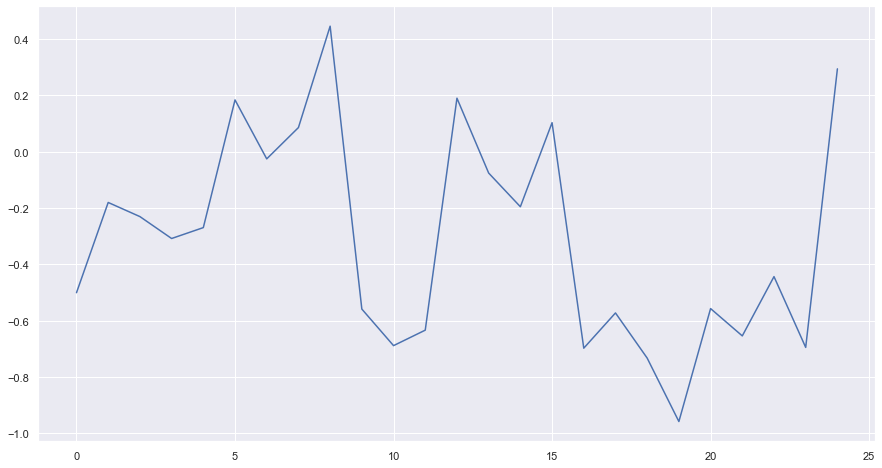

ПЕРВЫЙ КАНАЛ | Все 18+_Share


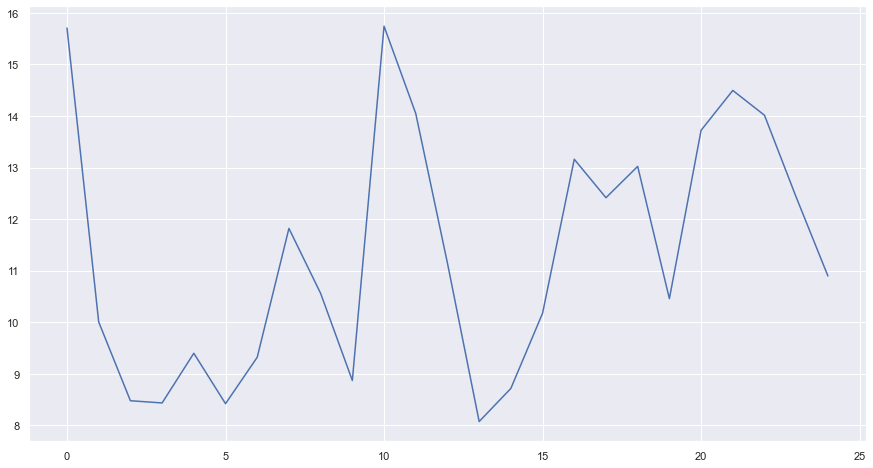

ПЕРВЫЙ КАНАЛ | Все 18+_Share | ARCSIN


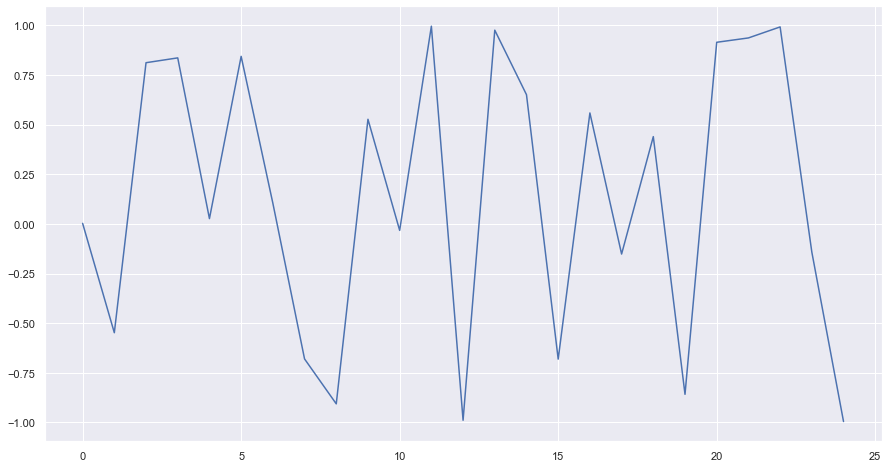

ПЕРВЫЙ КАНАЛ | Все 55+_Share


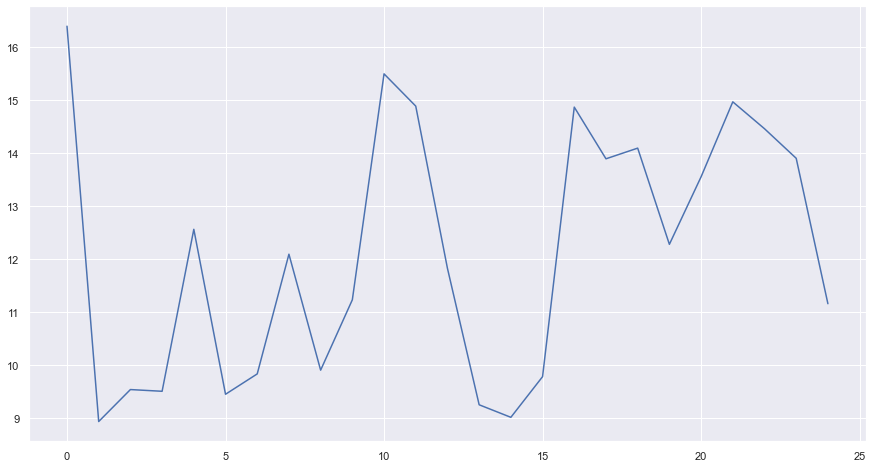

ПЕРВЫЙ КАНАЛ | Все 55+_Share | ARCSIN


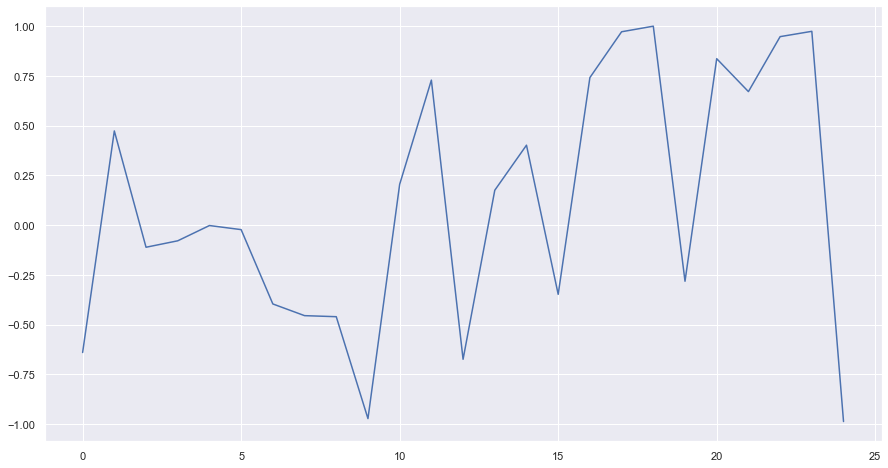

ПЕРВЫЙ КАНАЛ | Все 18+_TVR


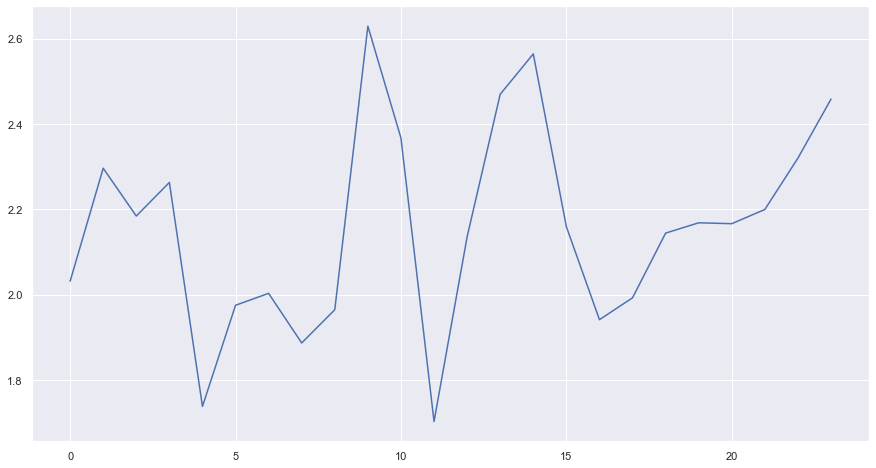

ПЕРВЫЙ КАНАЛ | Все 18+_TVR | ARCSIN


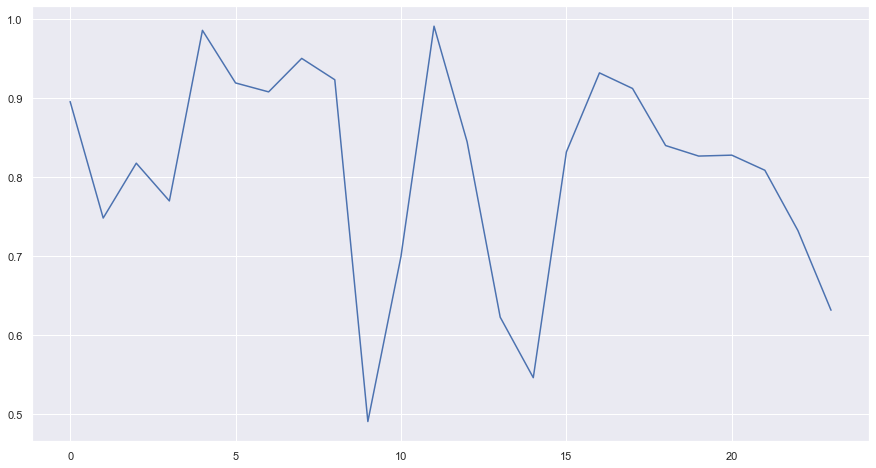

ПЕРВЫЙ КАНАЛ | Все 55+_TVR


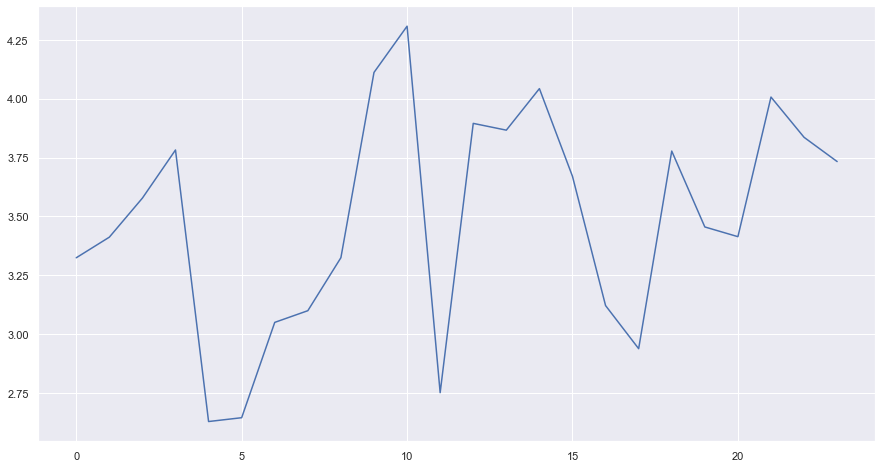

ПЕРВЫЙ КАНАЛ | Все 55+_TVR | ARCSIN


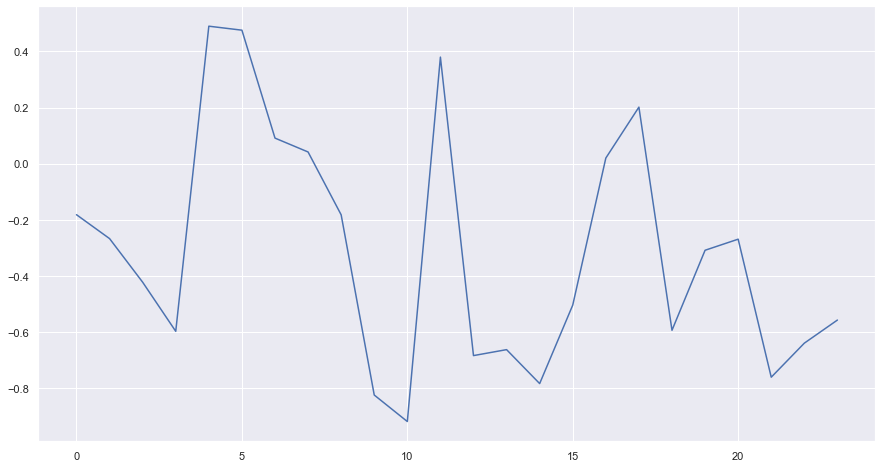

ПЕРВЫЙ КАНАЛ | Все 18+_Share


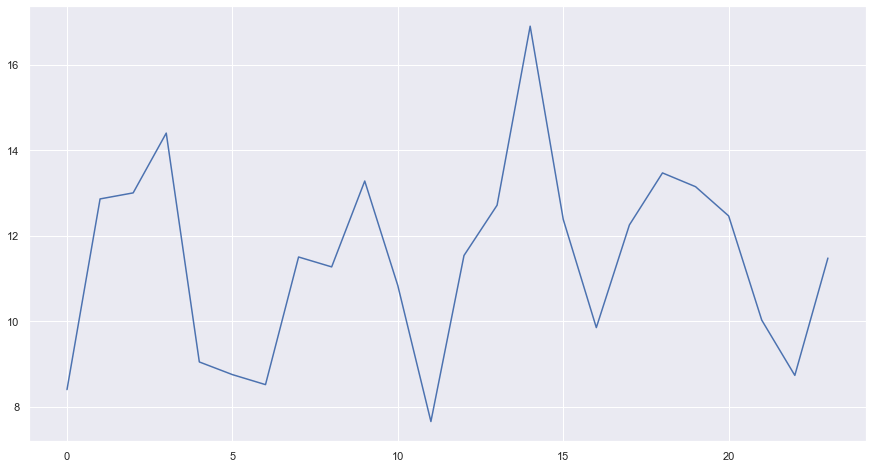

ПЕРВЫЙ КАНАЛ | Все 18+_Share | ARCSIN


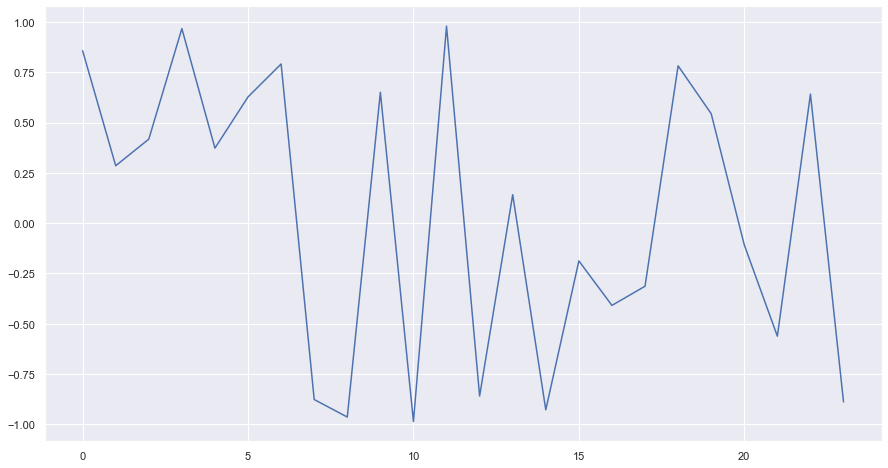

ПЕРВЫЙ КАНАЛ | Все 55+_Share


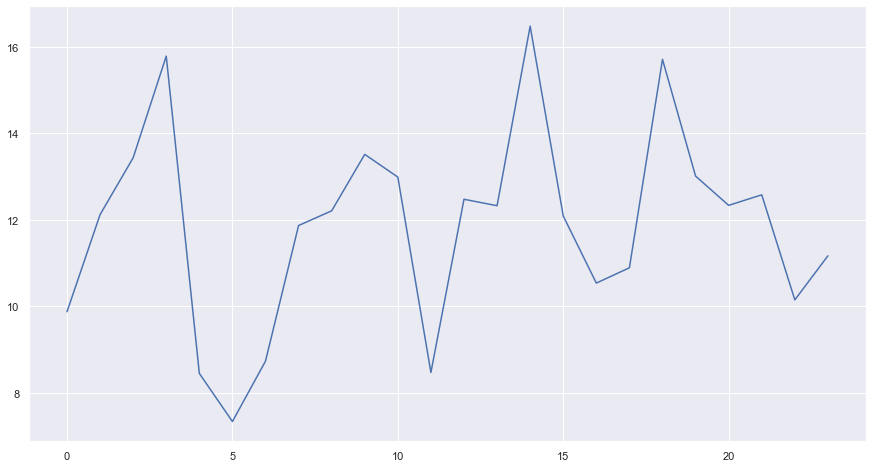

ПЕРВЫЙ КАНАЛ | Все 55+_Share | ARCSIN


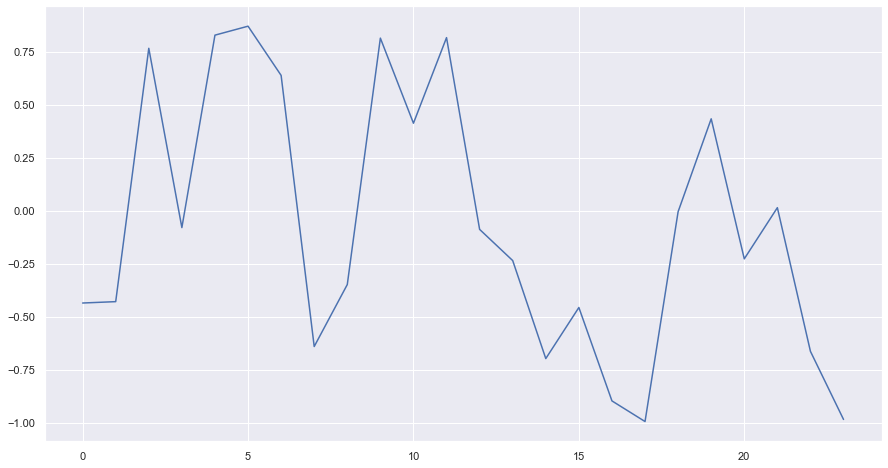

ПЕРВЫЙ КАНАЛ | Все 18+_TVR


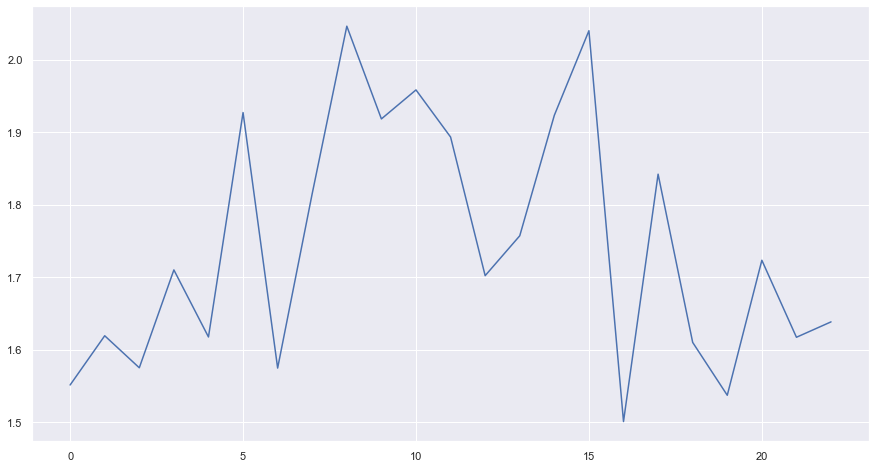

ПЕРВЫЙ КАНАЛ | Все 18+_TVR | ARCSIN


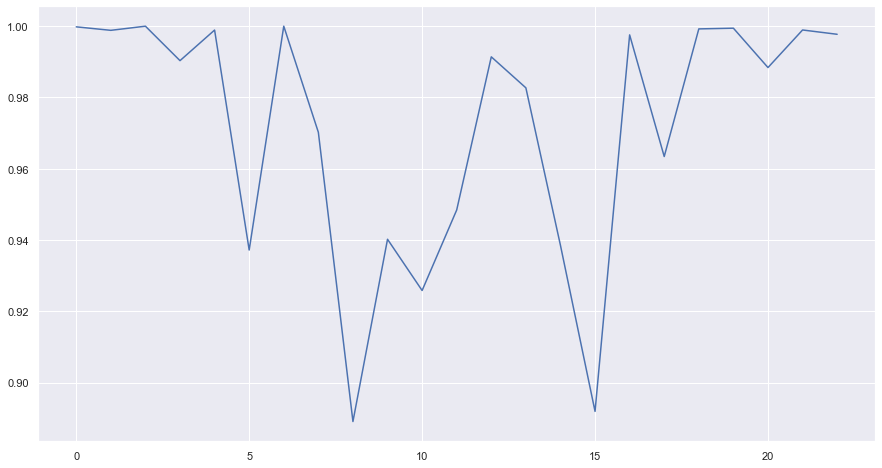

ПЕРВЫЙ КАНАЛ | Все 55+_TVR


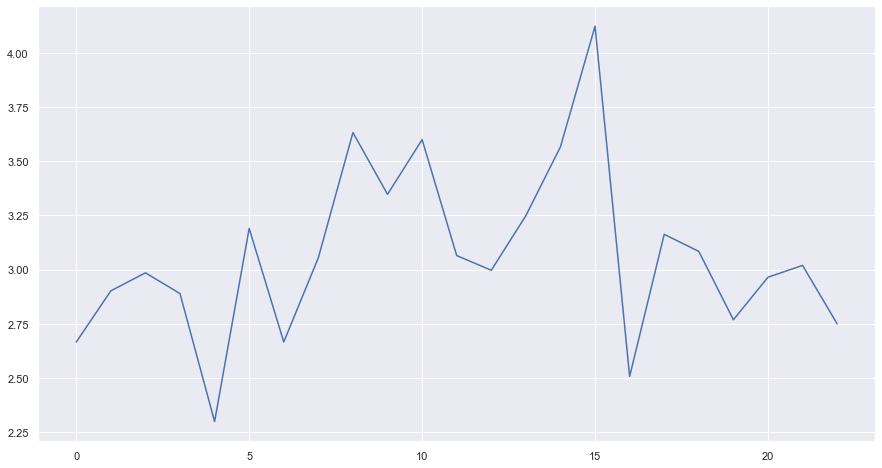

ПЕРВЫЙ КАНАЛ | Все 55+_TVR | ARCSIN


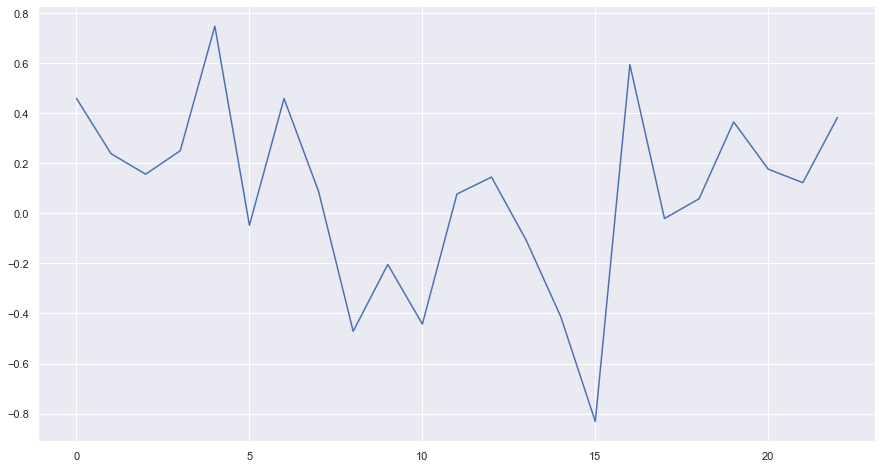

ПЕРВЫЙ КАНАЛ | Все 18+_Share


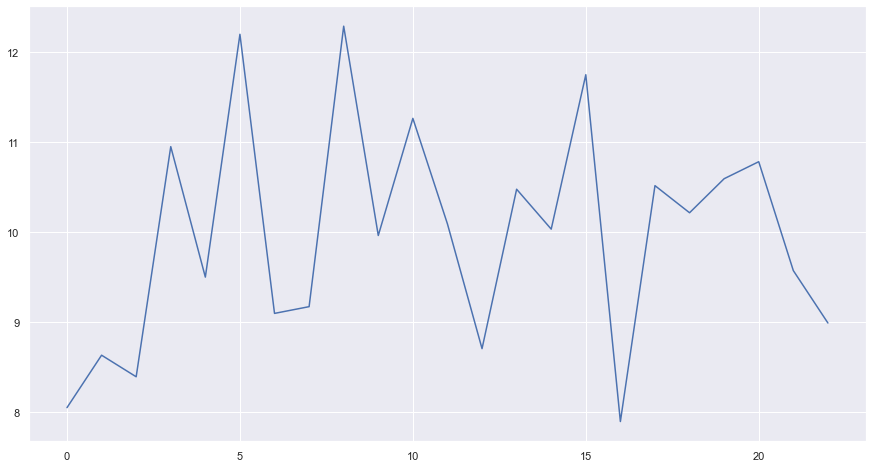

ПЕРВЫЙ КАНАЛ | Все 18+_Share | ARCSIN


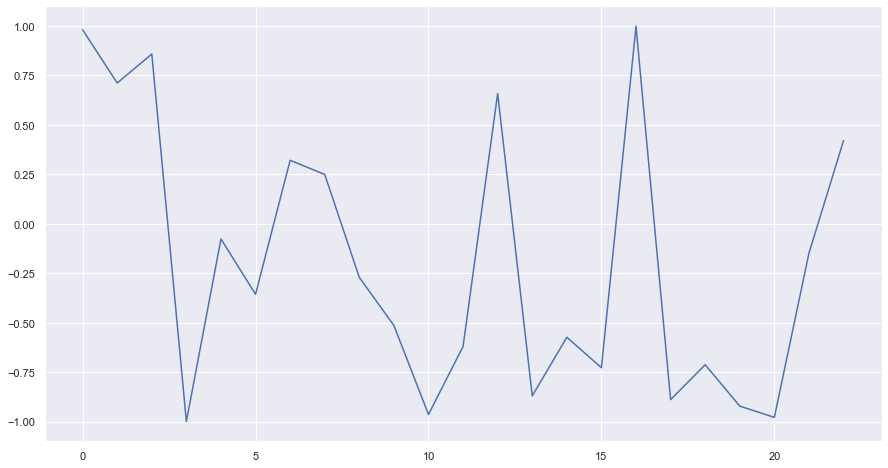

ПЕРВЫЙ КАНАЛ | Все 55+_Share


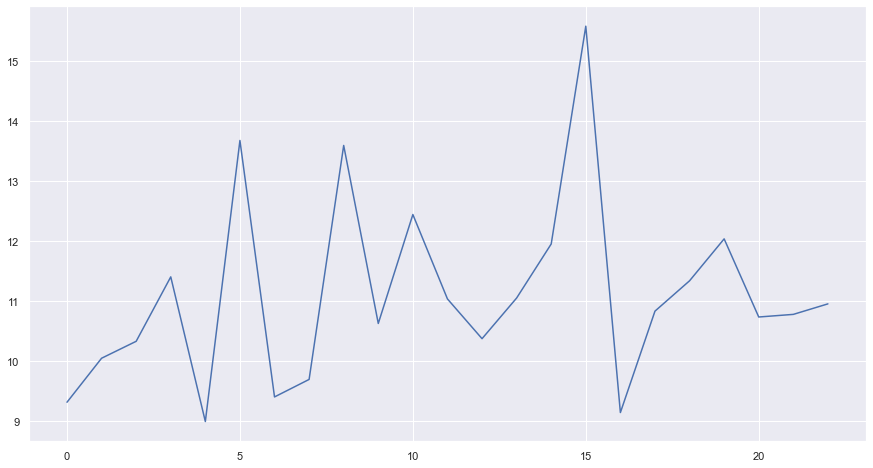

ПЕРВЫЙ КАНАЛ | Все 55+_Share | ARCSIN


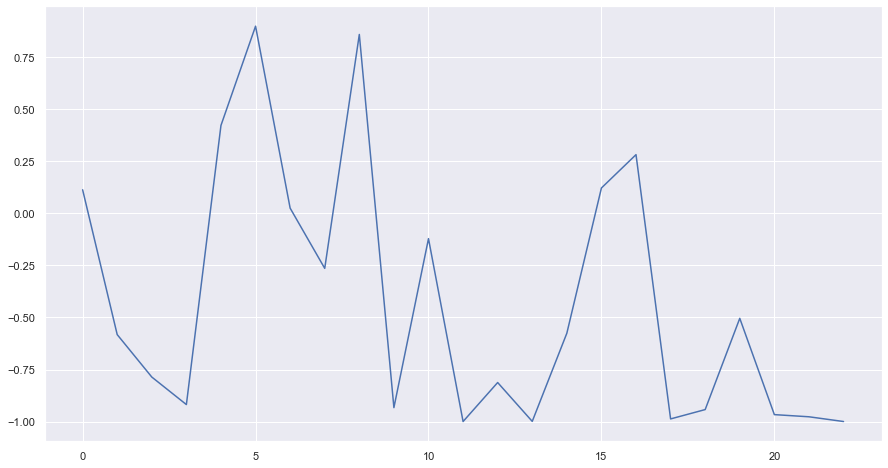

In [ ]:
for idx in range(0, 100, 10):
    d = get_month_avg(idx)
    for i in range(4):
        print(d['Канал'].iloc[0], '|', d.columns[i+3])
        plt.figure(figsize=(15, 8))
        plt.plot(np.arange(d.shape[0]), d.iloc[:, i+3])
        plt.show()
        print(d['Канал'].iloc[0], '|', d.columns[i+3], '| ARCSIN')
        plt.figure(figsize=(15, 8))
        plt.plot(np.arange(d.shape[0]), np.sin(d.iloc[:, i+3]))
        plt.show()

In [ ]:
train.iloc[:, :18]

,Канал,Все 18+_TVR,Все 55+_TVR,Все 18+_Share,Все 55+_Share,Дата,year,month,day,hour,dow,is_holiday,season,tod,TVR/SHARE_18+,TVR/SHARE_55+,Все 18+_TVR_sin,Все 55+_TVR_sin
0,ПЕРВЫЙ КАНАЛ,0.21,0.12,5.23,2.00,2018-11-01 05:00:00,2018,11,1,5,3,0,3,0,0.040153,0.060000,0.208460,0.119712
1,ПЕРВЫЙ КАНАЛ,0.71,0.33,11.23,4.90,2018-11-01 06:00:00,2018,11,1,6,3,0,3,0,0.063224,0.067347,0.651834,0.324043
2,ПЕРВЫЙ КАНАЛ,1.10,0.59,14.58,6.49,2018-11-01 07:00:00,2018,11,1,7,3,0,3,0,0.075446,0.090909,0.891207,0.556361
3,ПЕРВЫЙ КАНАЛ,0.96,0.94,10.41,7.41,2018-11-01 08:00:00,2018,11,1,8,3,0,3,1,0.092219,0.126856,0.819192,0.807558
4,ПЕРВЫЙ КАНАЛ,1.94,3.81,17.54,21.51,2018-11-01 09:00:00,2018,11,1,9,3,0,3,1,0.110604,0.177127,0.932615,-0.619737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70075,ТНТ,1.17,0.39,6.08,1.65,2020-11-01 00:00:00,2020,11,1,0,6,1,3,0,0.192434,0.236364,0.920751,0.380188
70076,ТНТ,0.79,0.01,6.45,0.06,2020-11-01 01:00:00,2020,11,1,1,6,1,3,0,0.122481,0.166667,0.710353,0.010000
70077,ТНТ,0.04,0.03,0.53,0.28,2020-11-01 02:00:00,2020,11,1,2,6,1,3,0,0.075472,0.107143,0.039989,0.029996
70078,ТНТ,0.23,0.37,4.71,5.79,2020-11-01 03:00:00,2020,11,1,3,6,1,3,0,0.048832,0.063903,0.227978,0.361615


In [ ]:
#All time
train_agg_df = train.iloc[:, :20].drop(['year', 'month', 'day', 'tod', 'hour', 'dow', 'is_holiday', 'Дата', 'season'], axis=1).groupby(['Канал']).agg(['mean', 'max', 'std', 'median']).reset_index()
train_agg_df.columns = [col[0] if col[1] == '' else '_'.join(col)+'_all_time' for col in train_agg_df.columns]
train = train.merge(train_agg_df, on='Канал', how='left')
test = test.merge(train_agg_df, on='Канал', how='left')

# Year
train_agg_df = train.iloc[:, :20].drop(['month', 'day', 'hour', 'tod', 'dow', 'is_holiday', 'Дата', 'season'], axis=1).groupby(['Канал', 'year']).agg(['mean', 'max', 'std', 'median']).reset_index()
train_agg_df.columns = [col[0] if col[1] == '' else '_'.join(col)+'_year' for col in train_agg_df.columns]
train = train.merge(train_agg_df, on=['Канал', 'year'], how='left')
test = test.merge(train_agg_df, on=['Канал', 'year'], how='left')

# Month
train_agg_df = train.iloc[:, :20].drop(['day', 'hour', 'tod', 'dow', 'is_holiday', 'Дата', 'season'], axis=1).groupby(['Канал', 'year', 'month']).agg(['mean', 'max', 'std', 'median']).reset_index()
train_agg_df.columns = [col[0] if col[1] == '' else '_'.join(col)+'_month' for col in train_agg_df.columns]
train = train.merge(train_agg_df, on=['Канал', 'year', 'month'], how='left')
test = test.merge(train_agg_df, on=['Канал', 'year', 'month'], how='left')

# Hour
train_agg_df = train.iloc[:, :20].drop(['year', 'month', 'tod', 'day', 'dow', 'is_holiday', 'Дата', 'season'], axis=1).groupby(['Канал', 'hour']).agg(['mean', 'max', 'std', 'median']).reset_index()
train_agg_df.columns = [col[0] if col[1] == '' else '_'.join(col)+'_hour' for col in train_agg_df.columns]
train = train.merge(train_agg_df, on=['Канал', 'hour'], how='left')
test = test.merge(train_agg_df, on=['Канал', 'hour'], how='left')

# season
train_agg_df = train.iloc[:, :20].drop(['year', 'month', 'tod', 'day', 'hour', 'dow', 'is_holiday', 'Дата'], axis=1).groupby(['Канал', 'season']).agg(['mean', 'max', 'std', 'median']).reset_index()
train_agg_df.columns = [col[0] if col[1] == '' else '_'.join(col)+'_season' for col in train_agg_df.columns]
train = train.merge(train_agg_df, on=['Канал', 'season'], how='left')
test = test.merge(train_agg_df, on=['Канал', 'season'], how='left')

# tod
train_agg_df = train.iloc[:, :20].drop(['year', 'season', 'month', 'day', 'hour', 'dow', 'is_holiday', 'Дата'], axis=1).groupby(['Канал', 'tod']).agg(['mean', 'max', 'std', 'median']).reset_index()
train_agg_df.columns = [col[0] if col[1] == '' else '_'.join(col)+'_tod' for col in train_agg_df.columns]
train = train.merge(train_agg_df, on=['Канал', 'tod'], how='left')
test = test.merge(train_agg_df, on=['Канал', 'tod'], how='left')

# dow
train_agg_df = train.iloc[:, :20].drop(['year', 'season', 'month', 'day', 'tod', 'is_holiday', 'Дата'], axis=1).groupby(['Канал', 'dow', 'hour']).agg(['mean', 'max', 'std', 'median']).reset_index()
train_agg_df.columns = [col[0] if col[1] == '' else '_'.join(col)+'_dow_hour' for col in train_agg_df.columns]
train = train.merge(train_agg_df, on=['Канал', 'dow', 'hour'], how='left')
test = test.merge(train_agg_df, on=['Канал', 'dow', 'hour'], how='left')

In [ ]:
train = train.fillna(0)
test = test.fillna(0)
train.head()

,Канал,Все 18+_TVR,Все 55+_TVR,Все 18+_Share,Все 55+_Share,Дата,year,month,day,hour,...,Все 55+_TVR_sin_std_dow_hour,Все 55+_TVR_sin_median_dow_hour,Все 18+_Share_sin_mean_dow_hour,Все 18+_Share_sin_max_dow_hour,Все 18+_Share_sin_std_dow_hour,Все 18+_Share_sin_median_dow_hour,Все 55+_Share_sin_mean_dow_hour,Все 55+_Share_sin_max_dow_hour,Все 55+_Share_sin_std_dow_hour,Все 55+_Share_sin_median_dow_hour
0,ПЕРВЫЙ КАНАЛ,0.21,0.12,5.23,2.00,2018-11-01 05:00:00,2018,11,1,5,...,0.223517,0.361615,0.016250,0.999033,0.728902,-0.020218,0.028901,0.988168,0.689942,0.197813
1,ПЕРВЫЙ КАНАЛ,0.71,0.33,11.23,4.90,2018-11-01 06:00:00,2018,11,1,6,...,0.250774,0.597195,-0.013829,0.999526,0.736230,-0.014203,0.040549,0.998941,0.728135,0.056331
2,ПЕРВЫЙ КАНАЛ,1.10,0.59,14.58,6.49,2018-11-01 07:00:00,2018,11,1,7,...,0.195789,0.900793,0.027984,0.999561,0.729877,0.142477,0.001147,0.999083,0.728304,0.070084
3,ПЕРВЫЙ КАНАЛ,0.96,0.94,10.41,7.41,2018-11-01 08:00:00,2018,11,1,8,...,0.216079,0.940794,-0.161097,0.997024,0.652165,-0.249928,-0.011685,0.999351,0.685720,0.035787
4,ПЕРВЫЙ КАНАЛ,1.94,3.81,17.54,21.51,2018-11-01 09:00:00,2018,11,1,9,...,0.553475,0.622202,0.006267,0.993144,0.733476,0.179812,-0.053302,0.999461,0.698607,-0.071974


In [ ]:
import math
import os

In [ ]:
X = train.drop(list(train.columns[1:6])+['TVR/SHARE_18+', 'TVR/SHARE_55+', 'Все 18+_TVR_sin', 'Все 55+_TVR_sin', 'Все 18+_Share_sin', 'Все 55+_Share_sin'], axis=1)
X_test = test.drop(['Год', 'Месяц', 'День', 'Время', 'Дата_День', 'next_day', 'Дата'], axis=1)
y = train[train.columns[1:5]].values

In [ ]:
if not os.path.exists('models'):
    os.mkdir('models')

for i in range(4):
    model = cb.CatBoostRegressor(iterations=5000, eval_metric='RMSE', random_state=SEED, verbose=500, depth=5)
    model.fit(X, np.log(y[:, i]+1), [0])
    preds = math.e**model.predict(X_test)-1
    preds[preds < 0] = 0
    preds[preds > 100] = 100
    test.iloc[:, 5+i] = preds.copy()
    print(model.get_feature_importance(prettified=True)[:50])
    model.save_model(f'models/model{i}')

Learning rate set to 0.024474
0:	learn: 0.4550909	total: 56.8ms	remaining: 4m 43s
500:	learn: 0.1867776	total: 26.9s	remaining: 4m 1s
1000:	learn: 0.1803783	total: 54.9s	remaining: 3m 39s
1500:	learn: 0.1766540	total: 1m 34s	remaining: 3m 39s
2000:	learn: 0.1737665	total: 2m 12s	remaining: 3m 19s
2500:	learn: 0.1711995	total: 2m 51s	remaining: 2m 51s
3000:	learn: 0.1689220	total: 3m 32s	remaining: 2m 21s
3500:	learn: 0.1670213	total: 4m 5s	remaining: 1m 45s
4000:	learn: 0.1652023	total: 4m 36s	remaining: 1m 8s
4500:	learn: 0.1635196	total: 5m 9s	remaining: 34.3s
4999:	learn: 0.1620275	total: 5m 38s	remaining: 0us
                         Feature Id  Importances
0       Все 18+_TVR_median_dow_hour    29.135427
1         Все 18+_TVR_mean_dow_hour    23.353775
2     Все 18+_TVR_sin_mean_dow_hour     6.816878
3   Все 18+_TVR_sin_median_dow_hour     6.583703
4                               day     3.346860
5           TVR/SHARE_18+_max_month     1.227442
6                        is_holiday 

Learning rate set to 0.024474
0:	learn: 1.0167645	total: 132ms	remaining: 10m 58s
500:	learn: 0.5372533	total: 38s	remaining: 5m 41s
1000:	learn: 0.5241376	total: 1m 15s	remaining: 5m
1500:	learn: 0.5148334	total: 1m 51s	remaining: 4m 21s
2000:	learn: 0.5071378	total: 2m 26s	remaining: 3m 40s
2500:	learn: 0.5004721	total: 3m 2s	remaining: 3m 2s
3000:	learn: 0.4946629	total: 3m 40s	remaining: 2m 27s
3500:	learn: 0.4893376	total: 4m 18s	remaining: 1m 50s
4000:	learn: 0.4844496	total: 4m 55s	remaining: 1m 13s
4500:	learn: 0.4800051	total: 5m 31s	remaining: 36.8s
4999:	learn: 0.4758712	total: 6m 5s	remaining: 0us
                         Feature Id  Importances
0     Все 55+_Share_median_dow_hour    13.866126
1       Все 55+_Share_mean_dow_hour    10.383104
2                               day     6.281344
3       Все 18+_Share_mean_dow_hour     2.670005
4     Все 18+_Share_median_dow_hour     2.250508
5    Все 55+_Share_sin_std_dow_hour     1.949214
6           Все 55+_Share_mean_hour     

In [ ]:
test.iloc[:, :12].to_csv('test_predict ed.csv', index=False)